# Importar Librerias

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np

# Mapeo y Correlación de Pérdida de Bosque y Especies Protegidas

CRS de especies: EPSG:4326
CRS de departamentos: EPSG:32616

Datos combinados limpios:
             NOMDEPTO  total_loss_ha  num_species
0           atlantida         988367            1
1           choluteca         153935            1
2               colon        3268094            1
3           comayagua         831898            1
4               copan         463474            2
5              cortes         785188            2
6          el paraiso         766030            1
7   francisco morazan        1059488            2
8      gracias a dios        3261080            1
9            intibuca         404122            2
10  islas de la bahia          38532            1
11             la paz         203205            1
12            lempira         426701            3
13         ocotepeque         136728            2
14            olancho        7714216            1
15      santa barbara        1094463            2
16              valle          71811            1
17           

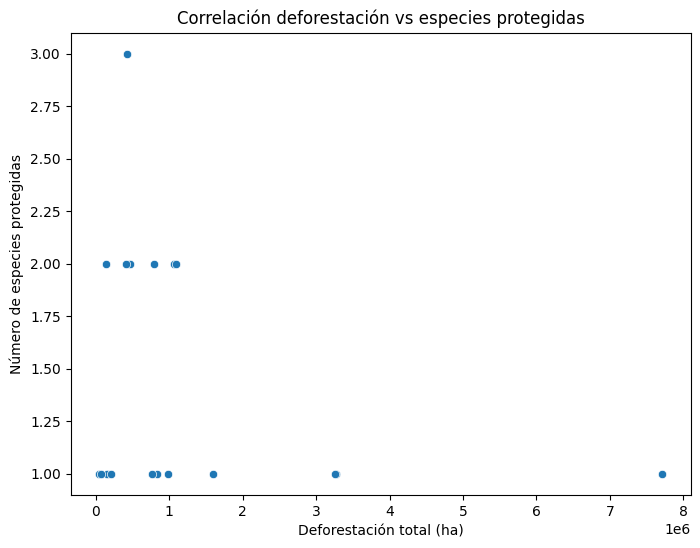

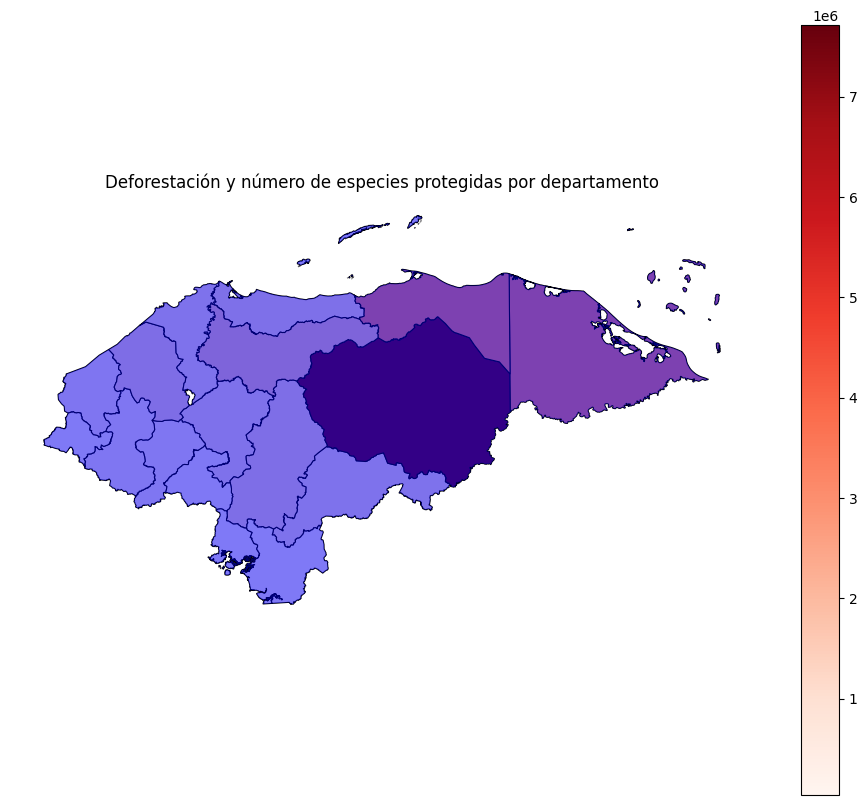

In [2]:
# === Función para normalizar nombres sin unidecode ===
def normalize_names_simple(df, col):
    replacements = {
        "á":"a", "é":"e", "í":"i", "ó":"o", "ú":"u",
        "ü":"u", "ñ":"n"
    }
    df[col] = df[col].astype(str).str.strip().str.lower()
    for orig, repl in replacements.items():
        df[col] = df[col].str.replace(orig, repl)
    return df

# === 1️. Leer shapefiles ===
species_gdf = gpd.read_file("datasets/data_0.shp")
gdf_depts = gpd.read_file("datasets/Departamentos_Honduras.shp")

# Revisar CRS
print("CRS de especies:", species_gdf.crs)
print("CRS de departamentos:", gdf_depts.crs)

# === 2️. Alinear CRS ===
species_gdf = species_gdf.to_crs(gdf_depts.crs)

# === 3. Join espacial ===
species_in_dept = gpd.sjoin(species_gdf, gdf_depts, how="inner", predicate="intersects")

# Columna de departamento real en tu shapefile
dept_col = "DEPTO"

# Contar especies únicas por departamento
species_stats = species_in_dept.groupby(dept_col)["SCI_NAME"].nunique().reset_index()
species_stats.rename(columns={dept_col: "NOMDEPTO", "SCI_NAME": "num_species"}, inplace=True)

# === 4️. Leer y limpiar datos de deforestación ===
file_path = "datasets/HND (2).xlsx"
sheets_deforestation = ["Subnational 1 tree cover loss", "Subnational 2 tree cover loss"]

df_def = pd.concat([pd.read_excel(file_path, sheet_name=s) for s in sheets_deforestation], ignore_index=True)
df_def.fillna(0, inplace=True)
loss_cols = [c for c in df_def.columns if c.startswith("tc_loss_ha_")]
df_def["total_loss_ha"] = df_def[loss_cols].sum(axis=1)

def_stats = df_def.groupby("subnational1")["total_loss_ha"].sum().reset_index()
def_stats.rename(columns={"subnational1": "NOMDEPTO"}, inplace=True)

# === 5️. Normalizar nombres ===
species_stats = normalize_names_simple(species_stats, "NOMDEPTO")
def_stats = normalize_names_simple(def_stats, "NOMDEPTO")
gdf_depts_norm = normalize_names_simple(gdf_depts.copy(), "DEPTO")

# === 6️. Combinar y agregar por departamento ===
merged = pd.merge(def_stats, species_stats, on="NOMDEPTO", how="outer").fillna(0)
merged = merged.groupby("NOMDEPTO").agg({
    "total_loss_ha": "sum",
    "num_species": "sum"
}).reset_index()

print("\nDatos combinados limpios:")
print(merged)

# === 7️. Correlación y scatterplot ===
corr = merged["total_loss_ha"].corr(merged["num_species"])
print("\nCorrelación entre deforestación y número de especies:", corr)

plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x="total_loss_ha", y="num_species")
plt.xlabel("Deforestación total (ha)")
plt.ylabel("Número de especies protegidas")
plt.title("Correlación deforestación vs especies protegidas")
plt.show()

# === 8️. Mapa geográfico ===
gdf_map = gdf_depts_norm.merge(merged, left_on="DEPTO", right_on="NOMDEPTO", how="left").fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(12,10))
gdf_map.plot(column="total_loss_ha", cmap="Reds", linewidth=0.8, edgecolor="black", legend=True, ax=ax)
gdf_map.plot(ax=ax, markersize=gdf_map["num_species"]*50, color="blue", alpha=0.5)  # tamaño de punto según número de especies
plt.title("Deforestación y número de especies protegidas por departamento")
plt.axis("off")
plt.show()



# Modelos de Regresión para Predecir Deforestación: Lineal vs Random Forest

=== Regresión lineal ===
Coeficiente: [-934928.8]
Intercepto: 2827325.366666666
R2 score: -0.13497915976577635
RMSE: 1121068.218958938

=== Random Forest ===
R2 score: -0.13480798540891037
RMSE: 1120983.677597248


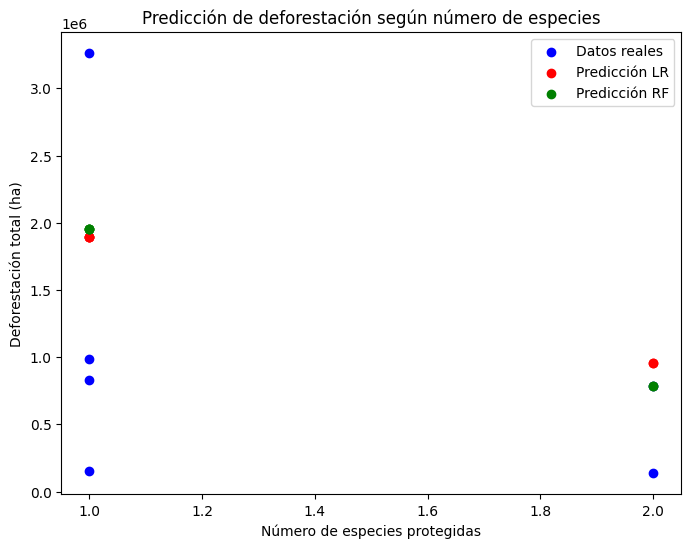

In [3]:
# === 1️. Definir variables ===
# merged es tu dataframe con columnas:
# 'NOMDEPTO', 'total_loss_ha', 'num_species'

X = merged[["num_species"]]  # predictor
y = merged["total_loss_ha"]  # variable a predecir

# === 2️. Separar train/test ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === 3️. Modelo de regresión lineal ===
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("=== Regresión lineal ===")
print("Coeficiente:", lr_model.coef_)
print("Intercepto:", lr_model.intercept_)
print("R2 score:", lr_model.score(X_test, y_test))  # otra forma de R²
print("RMSE:", rmse_lr)

# === 4️. Modelo Random Forest ===
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("\n=== Random Forest ===")
print("R2 score:", rf_model.score(X_test, y_test))
print("RMSE:", rmse_rf)

# === 5️. Gráfico comparativo ===
plt.figure(figsize=(8,6))
plt.scatter(X_test, y_test, color="blue", label="Datos reales")
plt.scatter(X_test, y_pred_lr, color="red", label="Predicción LR")
plt.scatter(X_test, y_pred_rf, color="green", label="Predicción RF")
plt.xlabel("Número de especies protegidas")
plt.ylabel("Deforestación total (ha)")
plt.title("Predicción de deforestación según número de especies")
plt.legend()
plt.show()




# Análisis de la Relación entre Deforestación y Especies Protegidas

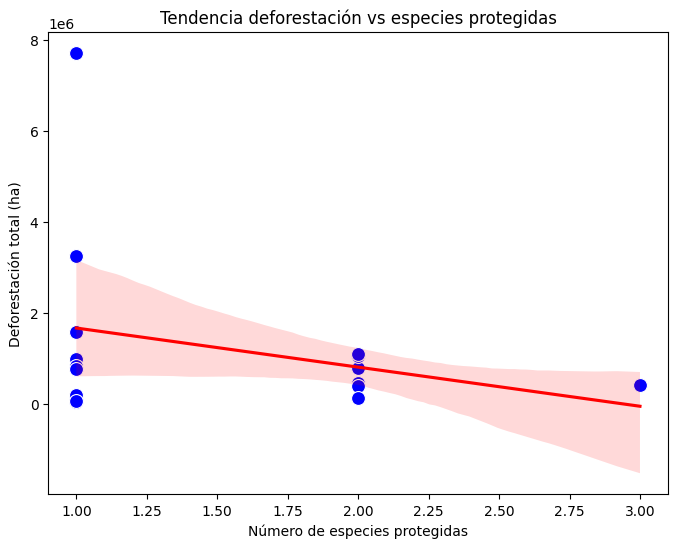

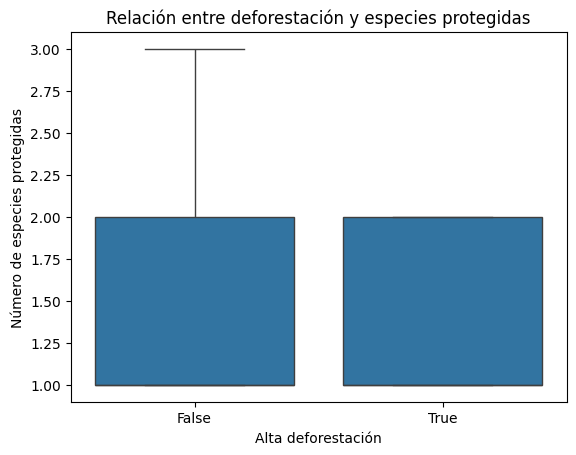

In [4]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged, x="num_species", y="total_loss_ha", s=100, color="blue")
sns.regplot(data=merged, x="num_species", y="total_loss_ha", scatter=False, color="red")
plt.xlabel("Número de especies protegidas")
plt.ylabel("Deforestación total (ha)")
plt.title("Tendencia deforestación vs especies protegidas")
plt.show()
merged["high_deforest"] = merged["total_loss_ha"] > merged["total_loss_ha"].median()
sns.boxplot(data=merged, x="high_deforest", y="num_species")
plt.xlabel("Alta deforestación")
plt.ylabel("Número de especies protegidas")
plt.title("Relación entre deforestación y especies protegidas")
plt.show()


# Evaluación Estadística de la Relación Deforestación vs Especies

In [6]:


# Calcular el coeficiente de Pearson entre deforestación y especies protegidas
coef, p_value = pearsonr(merged["num_species"], merged["total_loss_ha"])

print("=== Correlación de Pearson ===")
print("Coeficiente:", coef)
print("Valor p:", p_value)

# Interpretación rápida
if coef > 0:
    relacion = "positiva"
else:
    relacion = "negativa"

print(f"\nLa correlación es {relacion}.")
if abs(coef) < 0.3:
    print("La relación es débil o casi inexistente.")
elif abs(coef) < 0.7:
    print("La relación es moderada.")
else:
    print("La relación es fuerte.")

if p_value < 0.05:
    print("La correlación es estadísticamente significativa (p < 0.05).")
else:
    print("La correlación NO es estadísticamente significativa (p ≥ 0.05).")


=== Correlación de Pearson ===
Coeficiente: -0.2837296169251821
Valor p: 0.25387533290747094

La correlación es negativa.
La relación es débil o casi inexistente.
La correlación NO es estadísticamente significativa (p ≥ 0.05).


# Exploración y Visualización de Pérdida de Bosque y Emisiones de CO₂

Deforestación shape: (2528, 32)
Carbono shape: (2528, 34)

 Departamentos con más deforestación:
subnational1
Olancho              7714216
Colón                3268094
Gracias a Dios       3261080
Yoro                 1589050
Santa Bárbara        1094463
Francisco Morazán    1059488
Atlántida             988367
Comayagua             831898
Cortés                785188
El Paraíso            766030
Name: total_loss_ha, dtype: int64

 Departamentos con más emisiones de carbono:
subnational1
Olancho              1558662750
Gracias a Dios        683470518
Colón                 673595641
Yoro                  256501460
Atlántida             187912123
Santa Bárbara         186982592
Francisco Morazán     141834919
El Paraíso            133822722
Cortés                129936037
Comayagua             124968727
Name: total_emissions_MgCO2e, dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_7472\2151446483.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_def.values, y=top_def.index, palette="Reds_r")


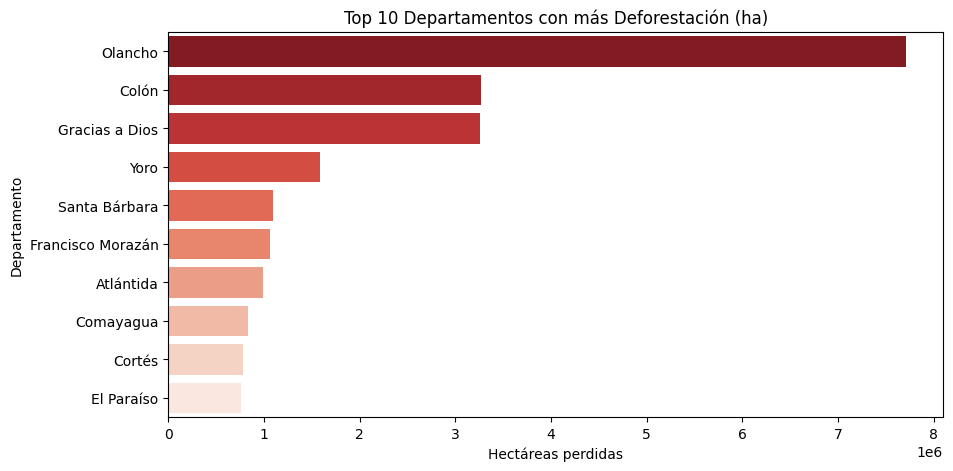

C:\Users\DELL\AppData\Local\Temp\ipykernel_7472\2151446483.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_carbon.values, y=top_carbon.index, palette="Blues_r")


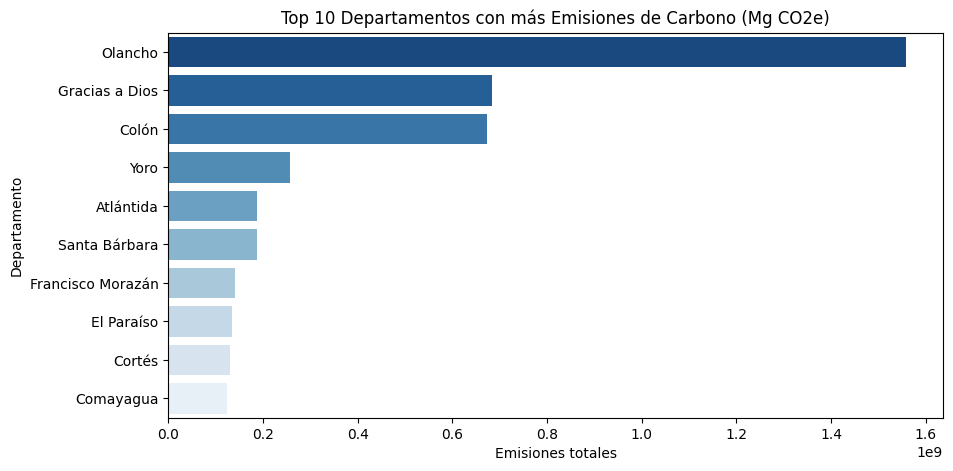

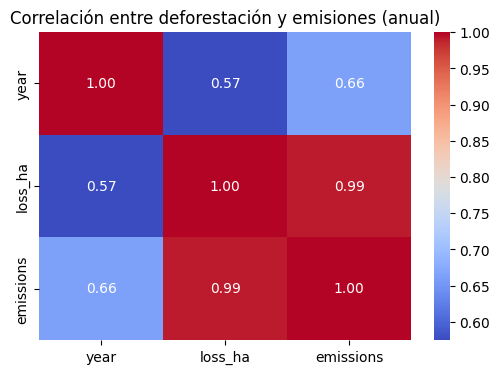

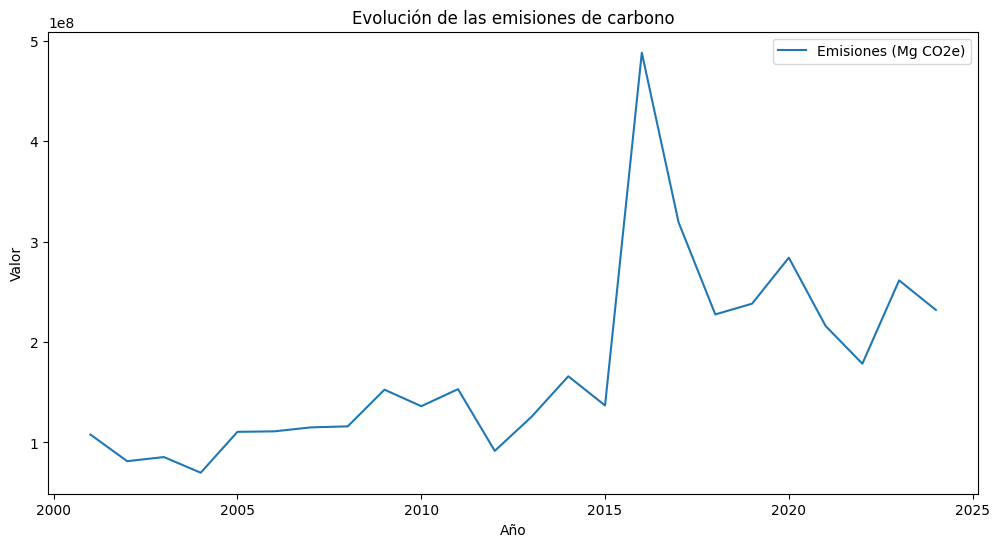


Estadísticas de deforestación por departamento:
                      mean           std   min     max
subnational1                                          
Atlántida     13727.319444  17745.943733  1019   68679
Choluteca      1131.875000   2256.592661    33   11762
Colón         37137.431818  60467.653356  2883  213417
Comayagua      4726.693182  10662.352587    20   57554
Copán          2413.927083   5690.077839   142   31743

Estadísticas de emisiones por departamento:
                      mean           std  min        max
subnational1                                            
Atlántida     2.609891e+06  6.457178e+06    0   32655899
Choluteca     1.433362e+05  5.052178e+05    0    4056499
Colón         7.654496e+06  2.297839e+07    0  114220946
Comayagua     7.100496e+05  2.785476e+06    0   24404865
Copán         3.958729e+05  1.613666e+06    0   14085462


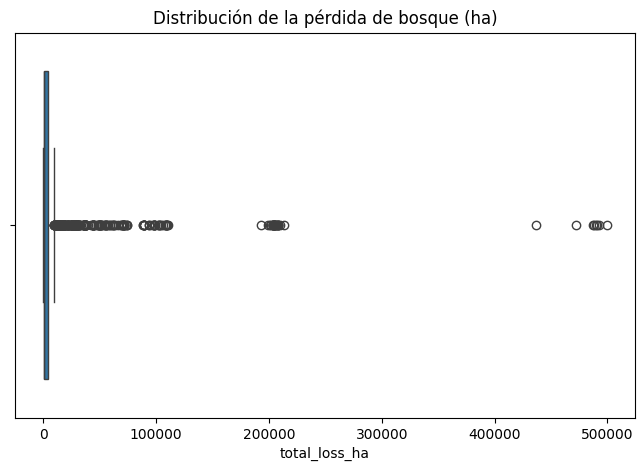

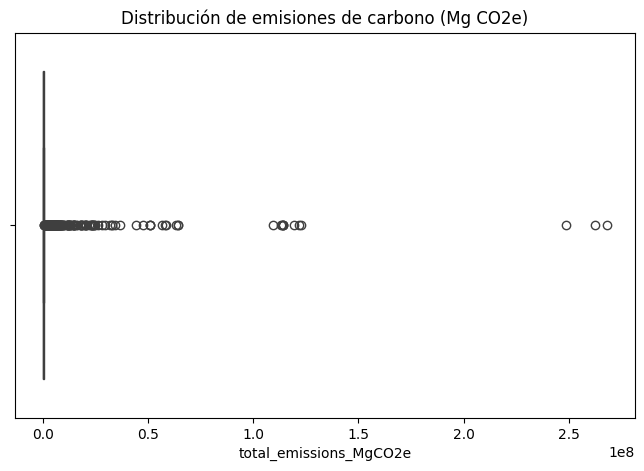

In [30]:
# === Cargar los datos ===
file_path = "datasets/HND (2).xlsx"

sheets_deforestation = ["Subnational 1 tree cover loss", "Subnational 2 tree cover loss"]
sheets_carbon = ["Subnational 1 carbon data", "Subnational 2 carbon data"]

df_def = pd.concat([pd.read_excel(file_path, sheet_name=s) for s in sheets_deforestation], ignore_index=True)
df_carbon = pd.concat([pd.read_excel(file_path, sheet_name=s) for s in sheets_carbon], ignore_index=True)

print("Deforestación shape:", df_def.shape)
print("Carbono shape:", df_carbon.shape)

# === Limpieza y estandarización de datos ===
def clean_dataframe(df):
    # Rellenar valores faltantes numéricos con 0
    num_cols = df.select_dtypes(include=["number"]).columns
    df[num_cols] = df[num_cols].fillna(0)

    # Rellenar valores faltantes de texto con "Desconocido"
    obj_cols = df.select_dtypes(include=["object"]).columns
    df[obj_cols] = df[obj_cols].fillna("Desconocido")

    # Eliminar columnas duplicadas o con solo NaN
    df = df.loc[:, df.notna().any()]

    return df

df_def = clean_dataframe(df_def)
df_carbon = clean_dataframe(df_carbon)

# === Identificar columnas de interés ===
loss_cols = [c for c in df_def.columns if c.startswith("tc_loss_ha_")]
carbon_cols = [c for c in df_carbon.columns if c.startswith("gfw_forest_carbon_gross_emissions_")]

# === Calcular totales por fila ===
df_def["total_loss_ha"] = df_def[loss_cols].sum(axis=1)
df_carbon["total_emissions_MgCO2e"] = df_carbon[carbon_cols].sum(axis=1)

# === Ranking por subnacional1 ===
top_def = df_def.groupby("subnational1")["total_loss_ha"].sum().sort_values(ascending=False).head(10)
top_carbon = df_carbon.groupby("subnational1")["total_emissions_MgCO2e"].sum().sort_values(ascending=False).head(10)

print("\n Departamentos con más deforestación:")
print(top_def)

print("\n Departamentos con más emisiones de carbono:")
print(top_carbon)

# === Gráficos de barras ===
plt.figure(figsize=(10,5))
sns.barplot(x=top_def.values, y=top_def.index, palette="Reds_r")
plt.title("Top 10 Departamentos con más Deforestación (ha)")
plt.xlabel("Hectáreas perdidas")
plt.ylabel("Departamento")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x=top_carbon.values, y=top_carbon.index, palette="Blues_r")
plt.title("Top 10 Departamentos con más Emisiones de Carbono (Mg CO2e)")
plt.xlabel("Emisiones totales")
plt.ylabel("Departamento")
plt.show()

# === Función robusta para calcular totales anuales ===
def compute_yearly_totals(df, cols_prefix, value_name):
    """
    Suma los valores por columna (año) y devuelve un dataframe con columnas 'year' y 'value_name'.
    Maneja columnas sin años válidos y NaN.
    """
    # Filtramos columnas que corresponden al patrón
    cols = [c for c in df.columns if c.startswith(cols_prefix)]

    # Sumamos por columna
    yearly_sum = df[cols].sum().reset_index()
    yearly_sum.columns = ["year", value_name]

    # Extraemos el año de cuatro dígitos
    yearly_sum["year"] = yearly_sum["year"].str.extract(r"(\d{4})")[0]

    # Eliminamos filas sin año válido
    yearly_sum = yearly_sum.dropna(subset=["year"])

    # Convertimos a entero, usando Int64 para manejar NaN si quedara alguno
    yearly_sum["year"] = yearly_sum["year"].astype("Int64")

    return yearly_sum

# === Totales anuales robustos ===
loss_yearly = compute_yearly_totals(df_def, "tc_loss_ha_", "loss_ha")
carbon_yearly = compute_yearly_totals(df_carbon, "gfw_forest_carbon_gross_emissions_", "emissions")

# Merge de ambos dataframes
merged_yearly = pd.merge(loss_yearly, carbon_yearly, on="year", how="outer").fillna(0)

# === Mapa de calor de correlación ===
plt.figure(figsize=(6,4))
sns.heatmap(merged_yearly.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre deforestación y emisiones (anual)")
plt.show()

# === Serie temporal ===
plt.figure(figsize=(12,6))
sns.lineplot(data=merged_yearly, x="year", y="emissions", label="Emisiones (Mg CO2e)")
plt.title("Evolución de las emisiones de carbono")
plt.xlabel("Año")
plt.ylabel("Valor")
plt.legend()
plt.show()

# Promedio y desviación estándar por departamento
stats_def = df_def.groupby("subnational1")["total_loss_ha"].agg(["mean", "std", "min", "max"])
stats_carbon = df_carbon.groupby("subnational1")["total_emissions_MgCO2e"].agg(["mean", "std", "min", "max"])

print("\nEstadísticas de deforestación por departamento:")
print(stats_def.head())

print("\nEstadísticas de emisiones por departamento:")
print(stats_carbon.head())

# Boxplot para ver la dispersión
plt.figure(figsize=(8,5))
sns.boxplot(x=df_def["total_loss_ha"])
plt.title("Distribución de la pérdida de bosque (ha)")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=df_carbon["total_emissions_MgCO2e"])
plt.title("Distribución de emisiones de carbono (Mg CO2e)")
plt.show()

# Heatmap de Temperaturas Históricas por Mes y Año

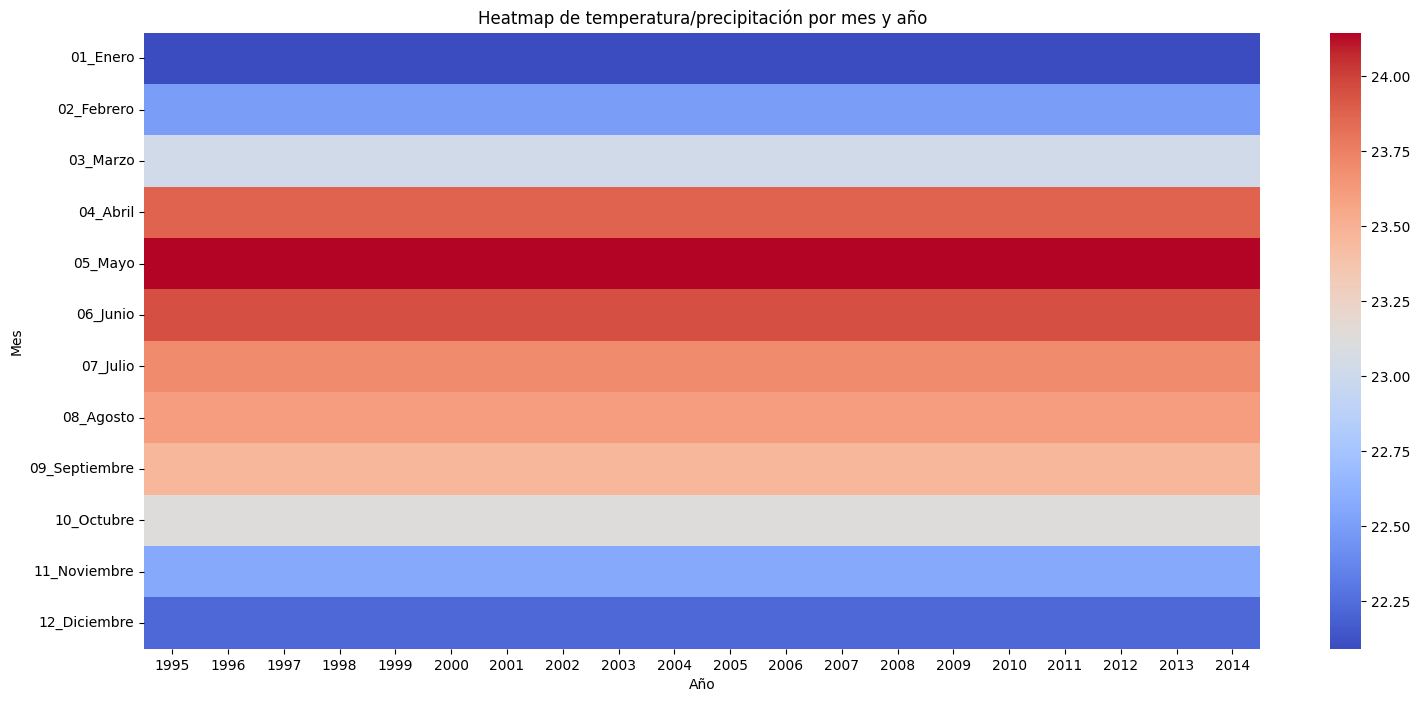

In [9]:
# === 1️. Cargar y expandir datos ===
file_path = "datasets/climatology_tas_monthly_mean_historical_1995_2014_8619667152400553730.xlsx"
df = pd.read_excel(file_path)

# Expandir los rangos de timeStep a años individuales
rows = []
for _, row in df.iterrows():
    start, end = map(int, row["timeStep"].split("-"))
    for year in range(start, end+1):
        rows.append({
            "uniqueID": row["uniqueID"],
            "year": year,
            "month": row["month"],
            "mean_historical": row["mean_historical"]
        })

df_expanded = pd.DataFrame(rows)

# === 2️. Pivot para heatmap (mes vs año) ===
heatmap_data = df_expanded.groupby(["year","month"])["mean_historical"].mean().reset_index()
heatmap_pivot = heatmap_data.pivot(index="month", columns="year", values="mean_historical")

# Ordenar meses correctamente si están en texto
meses_orden = ["01_Enero","02_Febrero","03_Marzo","04_Abril","05_Mayo","06_Junio",
               "07_Julio","08_Agosto","09_Septiembre","10_Octubre","11_Noviembre","12_Diciembre"]
heatmap_pivot = heatmap_pivot.reindex(meses_orden)

# === 3️. Crear heatmap ===
plt.figure(figsize=(18,8))
sns.heatmap(heatmap_pivot, cmap="coolwarm", annot=False)
plt.title("Heatmap de temperatura/precipitación por mes y año")
plt.xlabel("Año")
plt.ylabel("Mes")
plt.show()



# Mapa de Temperatura Promedio Histórica por Departamento en Honduras


Index(['fid', 'OBJECTID', 'COD', 'DEPTO', 'Shape_Leng', 'Shape_Area', 'DEP',
       'CODPAIS', 'Km2', 'Densidad', 'geometry'],
      dtype='object')
   fid  OBJECTID COD              DEPTO     Shape_Leng    Shape_Area  DEP  \
0    1       1.0  01          Atlantida  550141.671520  4.362466e+09    1   
1    2       2.0  03          Comayagua  482034.509535  5.120776e+09    3   
2    3       3.0  04              Copan  301307.233673  3.239661e+09    4   
3    4       4.0  07         El Paraiso  707639.206148  7.383847e+09    7   
4    5       5.0  08  Francisco Morazan  576102.747613  8.580866e+09    8   

  CODPAIS      Km2  Densidad  \
0      HN  4362.47   72.2163   
1      HN  5120.78   64.8952   
2      HN  3239.66   85.2197   
3      HN  7383.85   44.8751   
4      HN  8580.87  129.3460   

                                            geometry  
0  POLYGON ((564401.385 1735255.674, 564398.26 17...  
1  POLYGON ((464339.598 1617673.613, 464339.223 1...  
2  POLYGON ((321934.439 164311

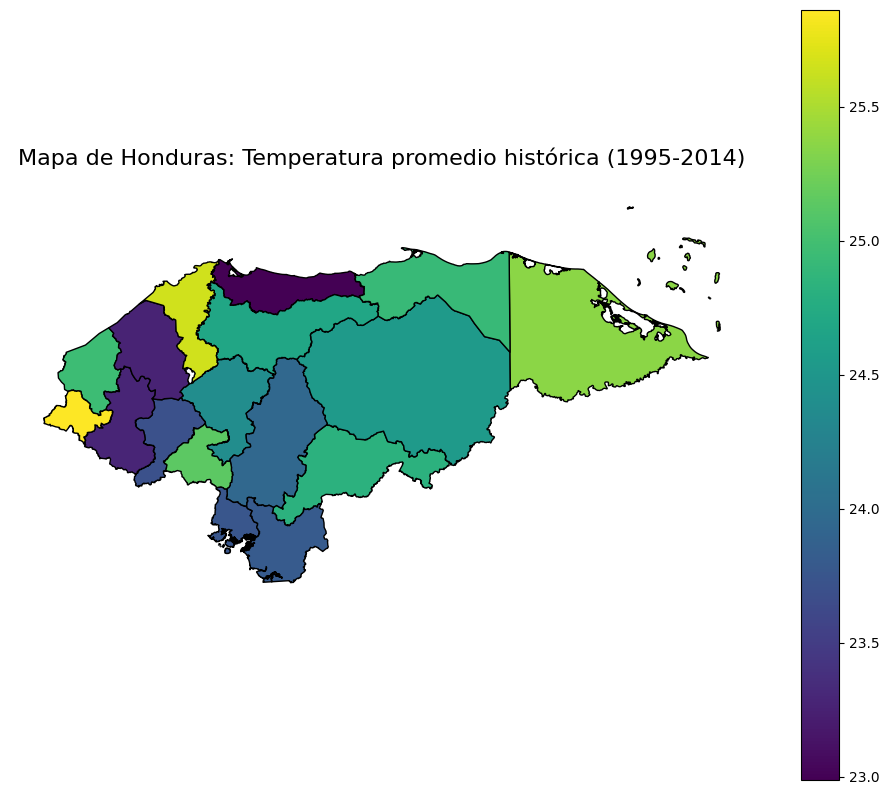


Estadísticas generales de temperatura (todas las zonas):
count    475.000000
mean      23.187314
std        1.732936
min       17.875595
25%       21.931934
50%       23.102636
75%       24.566370
max       26.586230
Name: MEAN, dtype: float64

 Estadísticas de temperatura por departamento:
                mean  std        min        max
DEPTO                                          
Atlantida  22.987343  NaN  22.987343  22.987343
Choluteca  23.805827  NaN  23.805827  23.805827
Colon      24.919743  NaN  24.919743  24.919743
Comayagua  24.388636  NaN  24.388636  24.388636
Copan      24.960249  NaN  24.960249  24.960249


In [25]:
# === 1️. Cargar shapefile de departamentos de Honduras ===
shapefile_path = "datasets/Departamentos_Honduras.shp"
gdf_depts = gpd.read_file(shapefile_path)

# Revisar columnas y geometría
print(gdf_depts.columns)
print(gdf_depts.head())

# === 2️. Cargar dataset con valores MEAN (temperatura promedio histórica) ===
data_path = "datasets/climatology_tas_annual_historical_4939504750478029426.xlsx"
df = pd.read_excel(data_path)

# Revisar columnas
print(df.columns)
print(df.head())

# === 3️. Mapear ZONE_CODE a departamentos ===
zone_to_dept = {
    1: "Atlantida", 2: "Choluteca", 3: "Colon", 4: "Comayagua",
    5: "Copan", 6: "Cortes", 7: "El Paraiso", 8: "Francisco Morazan",
    9: "Gracias a Dios", 10: "Intibuca", 11: "Islas de la Bahia",
    12: "La Paz", 13: "Lempira", 14: "Ocotepeque", 15: "Olancho",
    16: "Santa Barbara", 17: "Valle", 18: "Yoro"
}

df["DEPTO"] = df["ZONE_CODE"].map(zone_to_dept)

# Promediar MEAN por departamento
df_dept_mean = df.groupby("DEPTO")["MEAN"].mean().reset_index()
df_dept_mean.rename(columns={"MEAN": "TempPromedio"}, inplace=True)

# === 4️. Unir datos con shapefile ===
gdf_merged = gdf_depts.merge(df_dept_mean, left_on="DEPTO", right_on="DEPTO", how="left")

# === 5️. Graficar mapa temático ===
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_merged.plot(column="TempPromedio", cmap="viridis", legend=True, ax=ax, edgecolor="black")
ax.set_title("Mapa de Honduras: Temperatura promedio histórica (1995-2014)", fontsize=16)
ax.axis("off")
plt.show()

# === Estadísticas básicas generales ===
print("\nEstadísticas generales de temperatura (todas las zonas):")
print(df["MEAN"].describe())

# === Estadísticas por departamento ===
stats_temp = df.groupby("DEPTO")["MEAN"].agg(["mean", "std", "min", "max"])

print("\n Estadísticas de temperatura por departamento:")
print(stats_temp.head())


# Tendencia de Temperatura Histórica Anual y por Mes Clave (1995-2014)

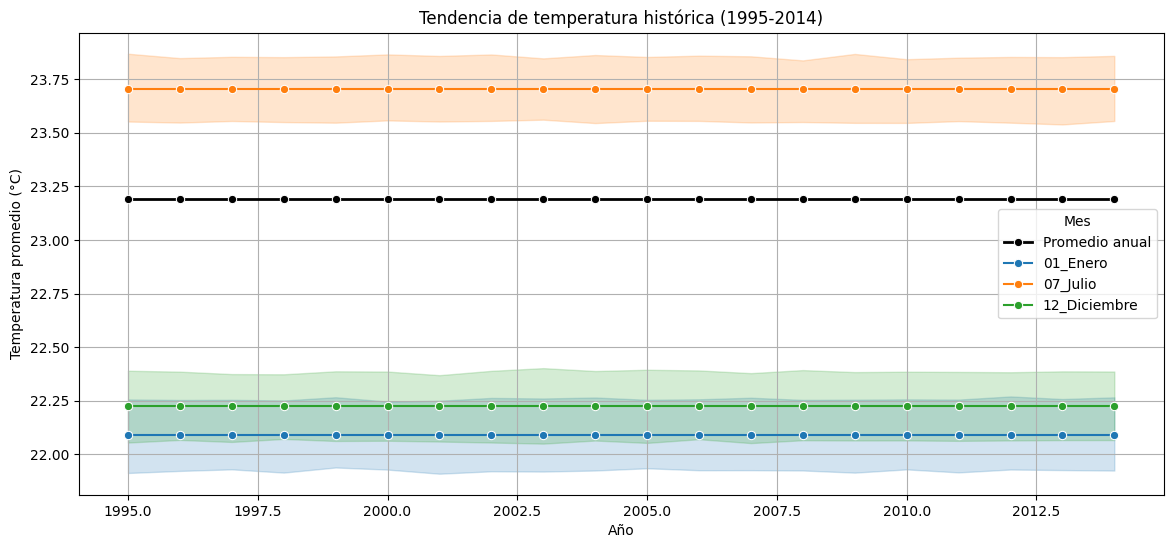

In [11]:
# === 1️. Cargar y expandir datos ===
file_path = "datasets/climatology_tas_monthly_mean_historical_1995_2014_8619667152400553730.xlsx"
df = pd.read_excel(file_path)

# Expandir los rangos de timeStep a años individuales
rows = []
for _, row in df.iterrows():
    start, end = map(int, row["timeStep"].split("-"))
    for year in range(start, end+1):
        rows.append({
            "uniqueID": row["uniqueID"],
            "year": year,
            "month": row["month"],
            "mean_historical": row["mean_historical"]
        })

df_expanded = pd.DataFrame(rows)

# === 2️. Promedio anual y meses clave ===
df_yearly = df_expanded.groupby("year")["mean_historical"].mean().reset_index()

meses_clave = ["01_Enero", "07_Julio", "12_Diciembre"]
df_subset = df_expanded[df_expanded["month"].isin(meses_clave)]

# === 3️. Gráfico combinado ===
plt.figure(figsize=(14,6))

# Línea promedio anual
sns.lineplot(data=df_yearly, x="year", y="mean_historical", marker="o", label="Promedio anual", color="black", linewidth=2)

# Líneas de meses clave
sns.lineplot(data=df_subset, x="year", y="mean_historical", hue="month", marker="o", palette="tab10")

plt.title("Tendencia de temperatura histórica (1995-2014)")
plt.xlabel("Año")
plt.ylabel("Temperatura promedio (°C)")
plt.grid(True)
plt.legend(title="Mes")
plt.show()



# Tendencias y Distribución de Precipitación Histórica


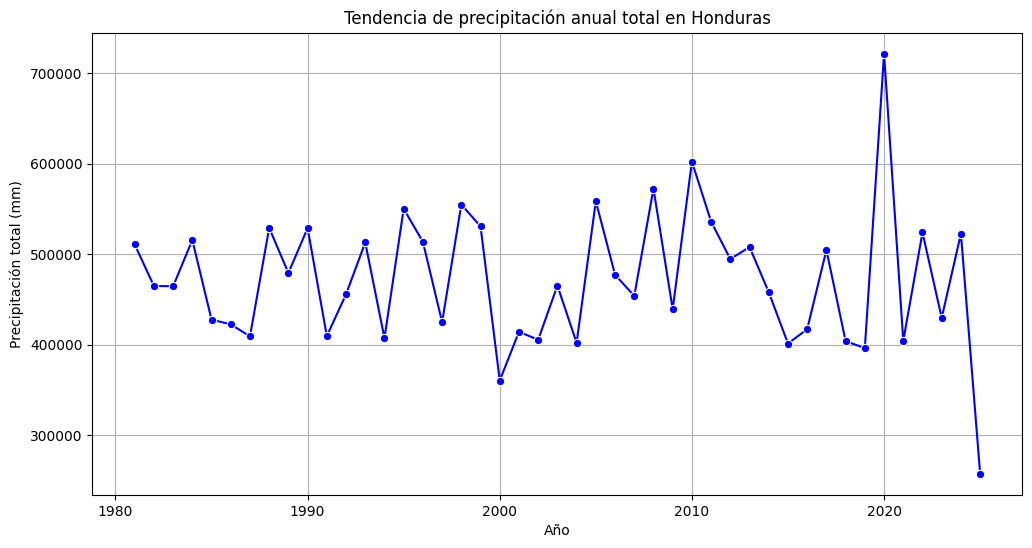

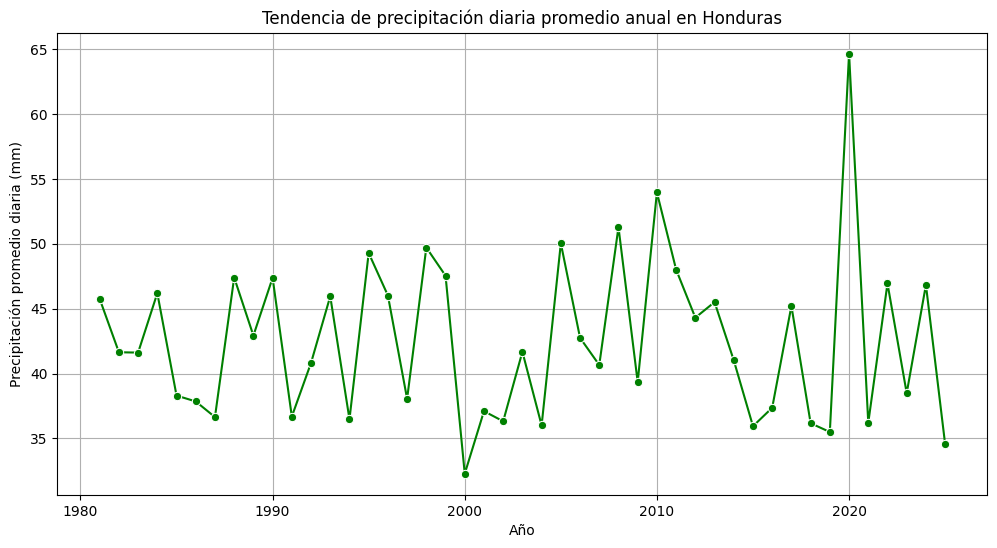

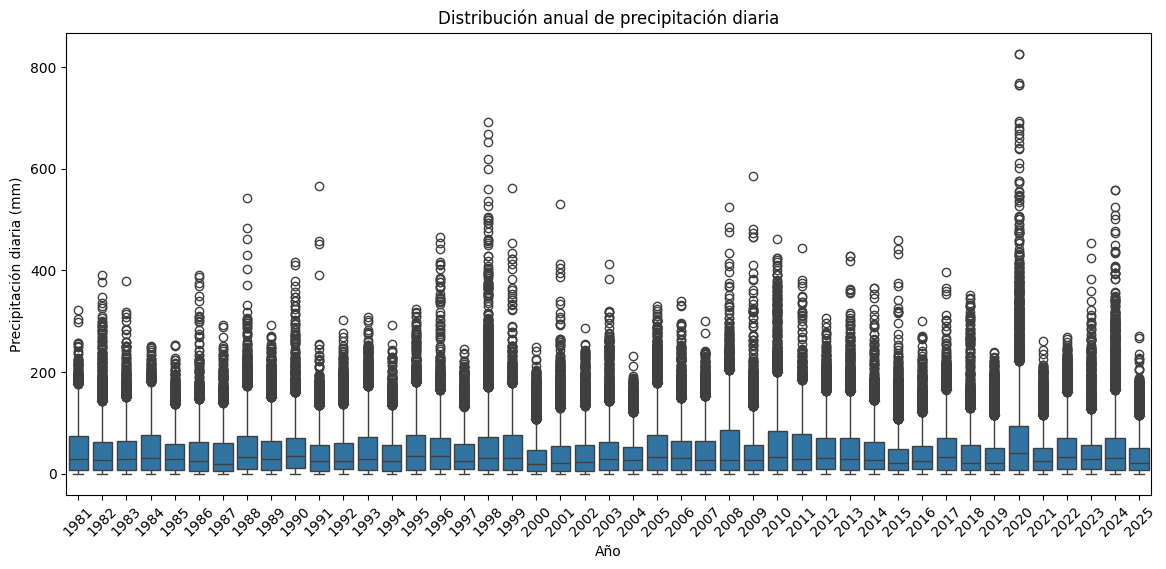

In [12]:
# === 1️. Cargar CSV ignorando comentarios y con todas las columnas ===
file_path = "datasets/hnd-rainfall-subnat-full.csv"
df = pd.read_csv(file_path, comment="#", low_memory=False)

# === 2️. Limpiar y preparar datos ===
df["date"] = pd.to_datetime(df["date"], errors="coerce")  # convertir fechas, no válidas se vuelven NaT
df = df.dropna(subset=["date", "rfh"])                     # eliminar filas sin fecha o sin precipitación
df["year"] = df["date"].dt.year                            # extraer año

# === 3️. Agrupar por año ===
# Suma total de precipitación por año para reflejar la variación real
precip_yearly = df.groupby("year")["rfh"].sum().reset_index()

# También podemos calcular el promedio diario por año
precip_avg_yearly = df.groupby("year")["rfh"].mean().reset_index()

# === 4️. Gráfico de tendencia anual (total) ===
plt.figure(figsize=(12,6))
sns.lineplot(data=precip_yearly, x="year", y="rfh", marker="o", color="blue")
plt.title("Tendencia de precipitación anual total en Honduras")
plt.xlabel("Año")
plt.ylabel("Precipitación total (mm)")
plt.grid(True)
plt.show()

# === 5️. Gráfico de tendencia anual (promedio diario) ===
plt.figure(figsize=(12,6))
sns.lineplot(data=precip_avg_yearly, x="year", y="rfh", marker="o", color="green")
plt.title("Tendencia de precipitación diaria promedio anual en Honduras")
plt.xlabel("Año")
plt.ylabel("Precipitación promedio diaria (mm)")
plt.grid(True)
plt.show()

# === 6️. Boxplot anual para ver variabilidad ===
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="year", y="rfh")
plt.title("Distribución anual de precipitación diaria")
plt.xlabel("Año")
plt.ylabel("Precipitación diaria (mm)")
plt.xticks(rotation=45)
plt.show()




# Análisis del Cambio Anual de Temperatura en Honduras

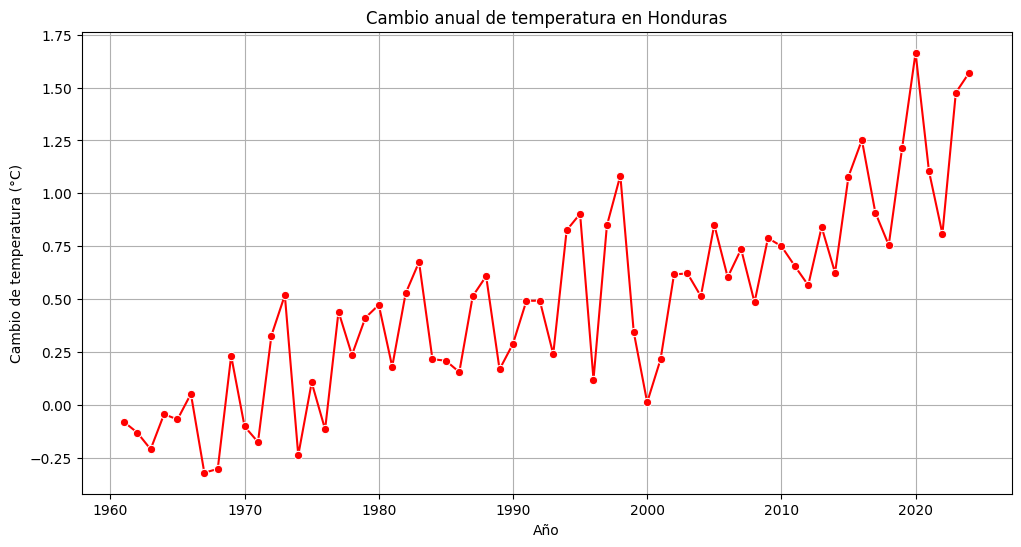

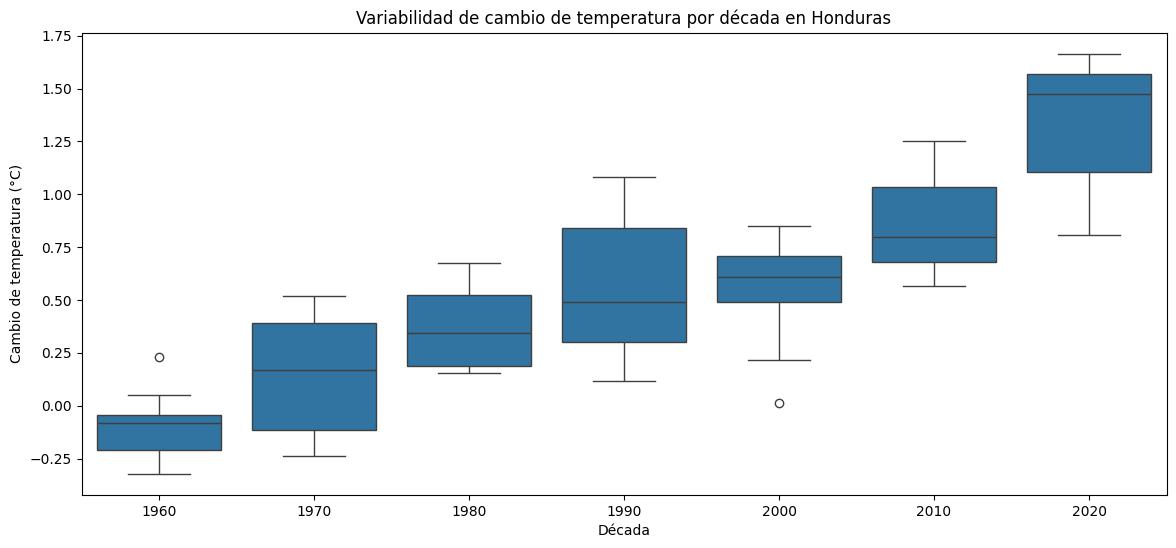

In [13]:
# === 1️. Cargar CSV ===
file_path = "datasets/23_Annual_Surface_Temperature_Change.csv"
df = pd.read_csv(file_path, low_memory=False)

# === 2️. Filtrar por país ===
country = "Honduras"
df_country = df[df["Country"] == country]

# === 3️. Seleccionar columnas de años ===
year_cols = [str(y) for y in range(1961, 2025)]  # Ajusta el rango según tus columnas
df_years = df_country[year_cols]

# === 4️. Transformar de wide a long ===
df_long = df_years.T.reset_index()
df_long.columns = ["year", "temperature_change"]
df_long["year"] = df_long["year"].astype(int)
df_long["temperature_change"] = pd.to_numeric(df_long["temperature_change"], errors="coerce")

# Eliminar posibles NaN
df_long = df_long.dropna(subset=["temperature_change"])

# === 5️. Gráfico de tendencia de temperatura ===
plt.figure(figsize=(12,6))
sns.lineplot(data=df_long, x="year", y="temperature_change", marker="o", color="red")
plt.title(f"Cambio anual de temperatura en {country}")
plt.xlabel("Año")
plt.ylabel("Cambio de temperatura (°C)")
plt.grid(True)
plt.show()

# === 6️. Boxplot por década para ver variabilidad ===
df_long["decade"] = (df_long["year"] // 10) * 10
plt.figure(figsize=(14,6))
sns.boxplot(data=df_long, x="decade", y="temperature_change")
plt.title(f"Variabilidad de cambio de temperatura por década en {country}")
plt.xlabel("Década")
plt.ylabel("Cambio de temperatura (°C)")
plt.show()


# Predicción de Temperatura Anual en Honduras mediante Regresión Lineal

=== Modelo de Regresión Lineal ===
Coeficiente: [0.02179307]
Intercepto: -42.95196940762131
R2 score: 0.6344649176380635
RMSE: 0.25090084957609077


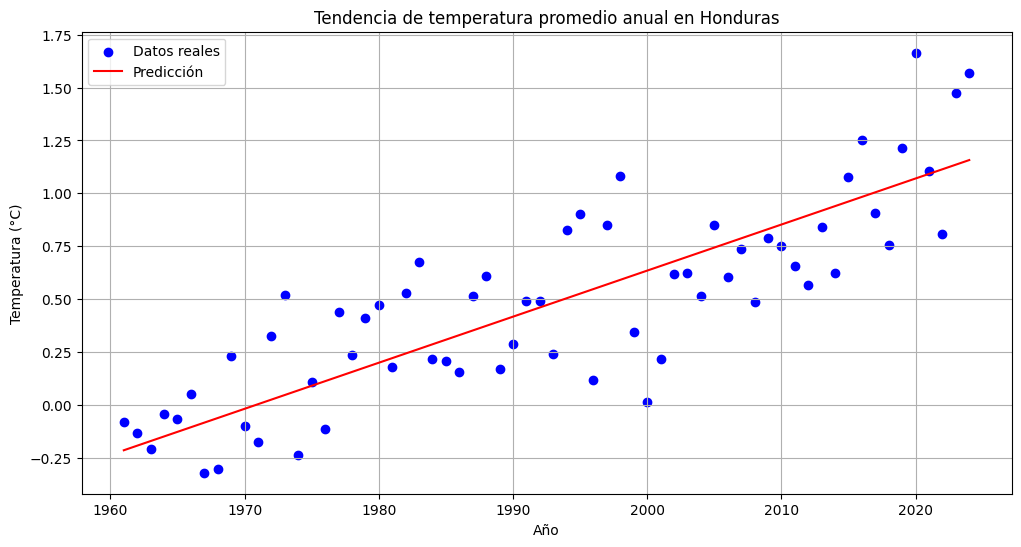

In [14]:
# === 1️. Cargar datos ===
file_path = "datasets/23_Annual_Surface_Temperature_Change.csv"
df = pd.read_csv(file_path)

# Seleccionamos solo un país para predecir, por ejemplo Honduras
df_country = df[df["Country"] == "Honduras"]

# Transponer los años a filas
years = list(range(1961, 2025))
temp_data = pd.DataFrame({
    "year": years,
    "temperature": df_country[[str(y) for y in years]].values.flatten()
})

# === 2️. Preparar X e y ===
X = temp_data[["year"]]   # variable independiente
y = temp_data["temperature"]  # variable dependiente

# === 3️. Dividir datos en entrenamiento y prueba ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 4️. Entrenar modelo de regresión lineal ===
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# === 5️. Predicciones ===
y_pred = lr_model.predict(X_test)

# === 6️. Evaluar modelo ===
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # √MSE

print("=== Modelo de Regresión Lineal ===")
print("Coeficiente:", lr_model.coef_)
print("Intercepto:", lr_model.intercept_)
print("R2 score:", r2)
print("RMSE:", rmse)

# === 7️. Visualización de la tendencia ===
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(X, y, color="blue", label="Datos reales")
plt.plot(X, lr_model.predict(X), color="red", label="Predicción")
plt.title("Tendencia de temperatura promedio anual en Honduras")
plt.xlabel("Año")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True)
plt.show()


# Predicción de Precipitación Anual Promedio en Honduras

=== Regresión Lineal de Precipitación ===
Coeficiente: [-0.01983541]
Intercepto: 82.10215131572377
R2 score: 0.0
RMSE: 0.36212413481158995


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


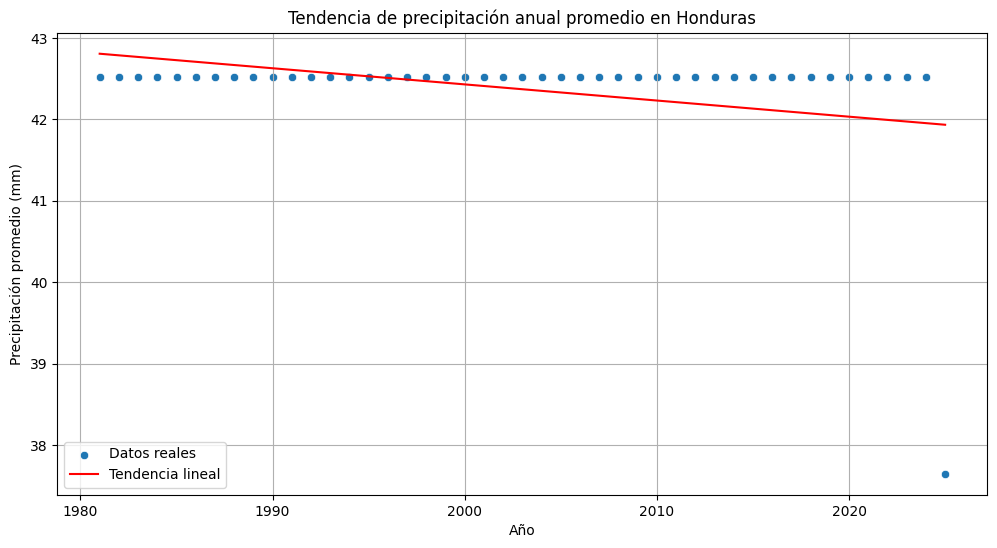

In [15]:
# === 1️. Cargar CSV de precipitación ===
file_path = "datasets/hnd-rainfall-subnat-full.csv"
df = pd.read_csv(file_path, comment="#", low_memory=False)

# === 2️. Limpiar y preparar datos ===
# Convertir columna 'date' a tipo fecha
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date", "rfh_avg"])  # eliminar filas sin fecha o precipitación
df["year"] = df["date"].dt.year             # extraer año

# === 3️. Agrupar por año para obtener precipitación promedio anual ===
precip_yearly = df.groupby("year")["rfh_avg"].mean().reset_index()

# === 4️. Preparar datos para regresión ===
X = precip_yearly[["year"]].values  # predictor: año
y = precip_yearly["rfh_avg"].values # variable a predecir: precipitación promedio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 5️. Entrenar modelo de regresión lineal ===
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# === 6️. Predecir y evaluar ===
y_pred = lr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # raíz cuadrada del MSE

print("=== Regresión Lineal de Precipitación ===")
print("Coeficiente:", lr_model.coef_)
print("Intercepto:", lr_model.intercept_)
print("R2 score:", r2)
print("RMSE:", rmse)

# === 7️. Graficar tendencia de precipitación ===
plt.figure(figsize=(12,6))
sns.scatterplot(x=precip_yearly["year"], y=precip_yearly["rfh_avg"], label="Datos reales")
sns.lineplot(x=precip_yearly["year"], y=lr_model.predict(precip_yearly[["year"]]), color="red", label="Tendencia lineal")
plt.title("Tendencia de precipitación anual promedio en Honduras")
plt.xlabel("Año")
plt.ylabel("Precipitación promedio (mm)")
plt.grid(True)
plt.legend()
plt.show()



# Relación entre Temperatura/Precipitación y Número de Especies Protegidas

Correlación clima (MEAN) - número de especies: 0.17161103249223247
p-value: 0.4959394420079325


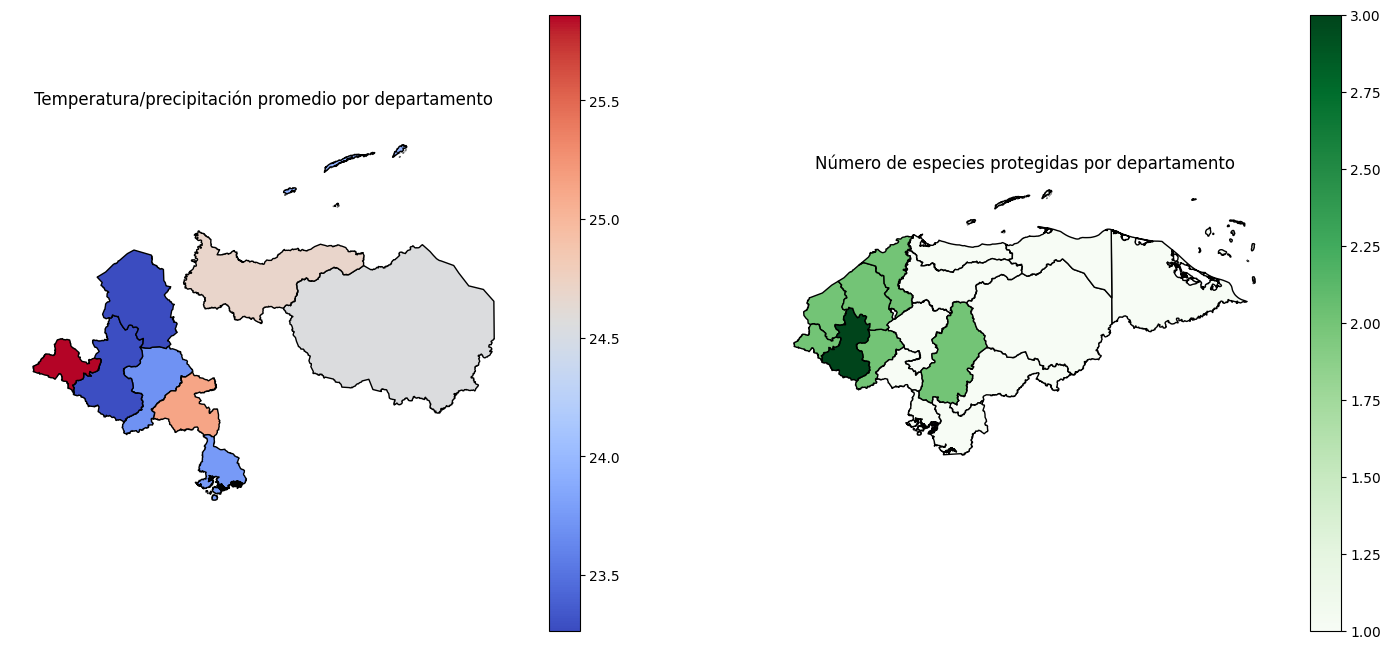

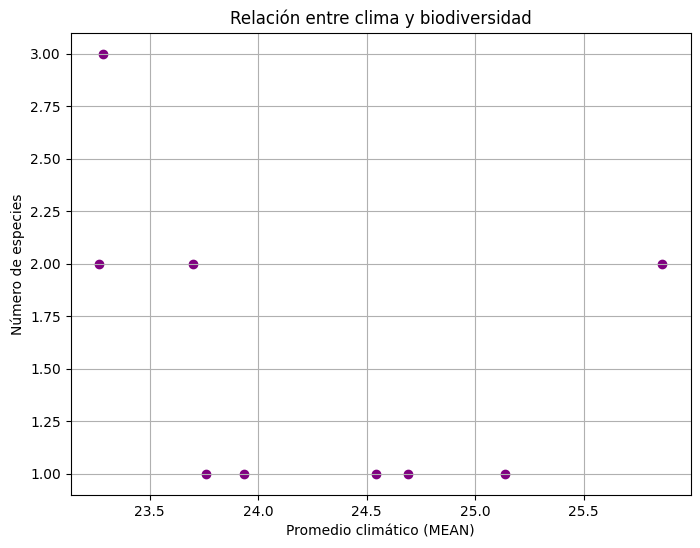

In [16]:
# === 1️. Cargar shapefiles de departamentos y especies ===
gdf_depts = gpd.read_file("datasets/Departamentos_Honduras.shp")
gdf_species = gpd.read_file("datasets/data_0.shp")

# Asegurarse que ambos shapefiles tengan el mismo CRS
gdf_species = gdf_species.to_crs(gdf_depts.crs)

# === 2️. Contar número de especies por departamento ===
species_in_dept = gpd.sjoin(gdf_species, gdf_depts, how="inner", predicate="intersects")
species_stats = species_in_dept.groupby("DEPTO")["SCI_NAME"].nunique().reset_index()
species_stats.rename(columns={"SCI_NAME":"num_species"}, inplace=True)

# === 3️. Cargar datos climáticos ===
climate_df = pd.read_excel("datasets/climatology_tas_annual_historical_4939504750478029426.xlsx")
# Agrupar por ZONE_CODE si hay duplicados
climate_stats = climate_df.groupby("ZONE_CODE")["MEAN"].mean().reset_index()

# === 4️. Convertir tipos para merge ===
gdf_depts["COD"] = gdf_depts["COD"].astype(str)
climate_stats["ZONE_CODE"] = climate_stats["ZONE_CODE"].astype(str)

# === 5️. Unir clima a departamentos ===
gdf_depts = gdf_depts.merge(climate_stats, left_on="COD", right_on="ZONE_CODE", how="left")

# === 6️. Unir número de especies a departamentos ===
gdf_depts = gdf_depts.merge(species_stats, on="DEPTO", how="left")

# === 7️. Calcular correlaciones ===
corr, p_val = pearsonr(gdf_depts['MEAN'].fillna(0), gdf_depts['num_species'].fillna(0))
print("Correlación clima (MEAN) - número de especies:", corr)
print("p-value:", p_val)

# === 8️. Graficar mapas temáticos ===
fig, axes = plt.subplots(1, 2, figsize=(18,8))

gdf_depts.plot(column="MEAN", cmap="coolwarm", legend=True, ax=axes[0], edgecolor="black")
axes[0].set_title("Temperatura/precipitación promedio por departamento")
axes[0].axis("off")

gdf_depts.plot(column="num_species", cmap="Greens", legend=True, ax=axes[1], edgecolor="black")
axes[1].set_title("Número de especies protegidas por departamento")
axes[1].axis("off")

plt.show()

# === 9️. Graficar scatter plot correlación ===
plt.figure(figsize=(8,6))
plt.scatter(gdf_depts['MEAN'], gdf_depts['num_species'], color='purple')
plt.xlabel("Promedio climático (MEAN)")
plt.ylabel("Número de especies")
plt.title("Relación entre clima y biodiversidad")
plt.grid(True)
plt.show()



# Relación entre Temperatura/Precipitación y Número de Especies Protegidas 2

Correlación clima (MEAN) - número de especies: -0.04580069929001322
p-value: 0.8567918224955547


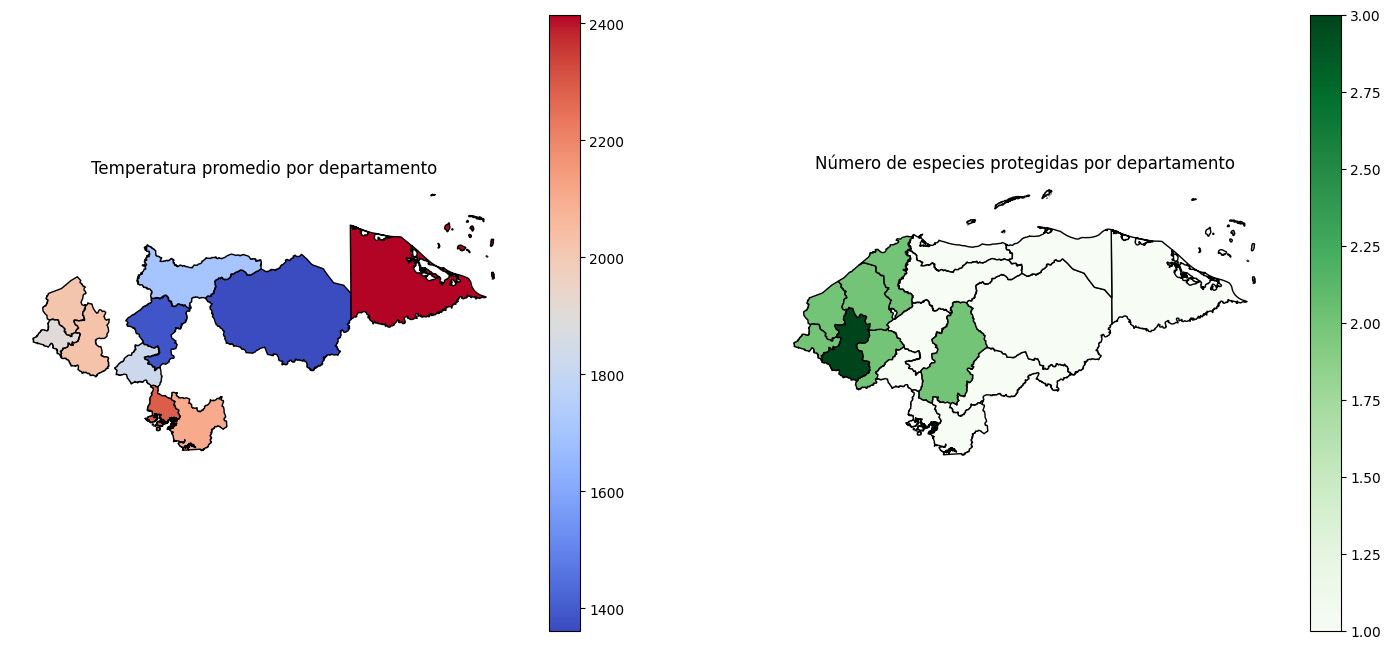

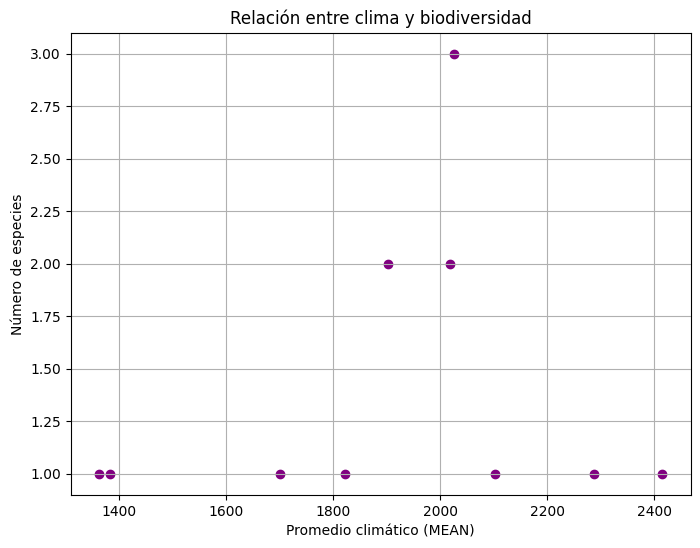

In [17]:
# === 1️. Cargar shapefiles de departamentos y especies ===
gdf_depts = gpd.read_file("datasets/Departamentos_Honduras.shp")
gdf_species = gpd.read_file("datasets/data_0.shp")

# Asegurar que ambos shapefiles tengan el mismo CRS
gdf_species = gdf_species.to_crs(gdf_depts.crs)

# === 2️. Contar número de especies por departamento ===
species_in_dept = gpd.sjoin(gdf_species, gdf_depts, how="inner", predicate="intersects")
species_stats = species_in_dept.groupby("DEPTO")["SCI_NAME"].nunique().reset_index()
species_stats.rename(columns={"SCI_NAME":"num_species"}, inplace=True)

# === 3️. Cargar datos climáticos ===
climate_df = pd.read_excel("datasets/climo_pr_annual_historical_fc_3727879312423714943.xlsx")

# Agrupar por departamento usando el nombre (NAME)
climate_stats = climate_df.groupby("NAME")["MEAN"].mean().reset_index()
climate_stats.rename(columns={"NAME":"DEPTO"}, inplace=True)

# === 4️. Unir clima y especies al shapefile de departamentos ===
gdf_depts = gdf_depts.merge(climate_stats, on="DEPTO", how="left")
gdf_depts = gdf_depts.merge(species_stats, on="DEPTO", how="left")

# === 5️. Calcular correlación clima vs especies ===
corr, p_val = pearsonr(gdf_depts['MEAN'].fillna(0), gdf_depts['num_species'].fillna(0))
print("Correlación clima (MEAN) - número de especies:", corr)
print("p-value:", p_val)

# === 6️. Graficar mapas temáticos ===
fig, axes = plt.subplots(1, 2, figsize=(18,8))

gdf_depts.plot(column="MEAN", cmap="coolwarm", legend=True, ax=axes[0], edgecolor="black")
axes[0].set_title("Temperatura promedio por departamento")
axes[0].axis("off")

gdf_depts.plot(column="num_species", cmap="Greens", legend=True, ax=axes[1], edgecolor="black")
axes[1].set_title("Número de especies protegidas por departamento")
axes[1].axis("off")

plt.show()

# === 7️. Scatter plot correlación ===
plt.figure(figsize=(8,6))
plt.scatter(gdf_depts['MEAN'], gdf_depts['num_species'], color='purple')
plt.xlabel("Promedio climático (MEAN)")
plt.ylabel("Número de especies")
plt.title("Relación entre clima y biodiversidad")
plt.grid(True)
plt.show()



# Top 10 Áreas Protegidas de Honduras por Superficie

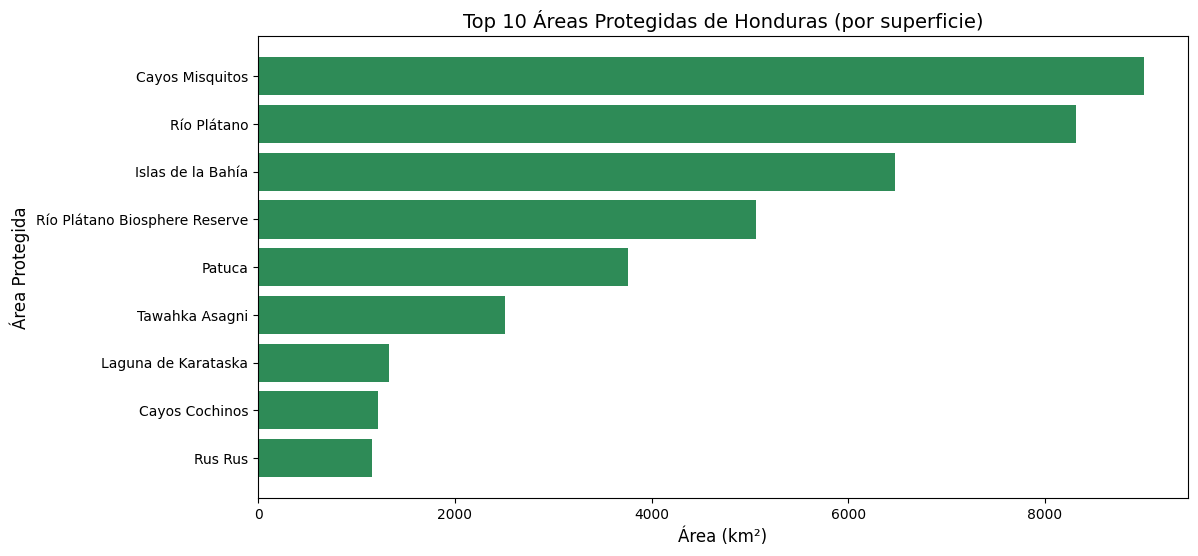

In [18]:
# Cargar dataset
areas_protegidas = pd.read_csv("datasets/WDPA_WDOECM_Aug2025_Public_HND_csv.csv")

# -------------------
# LIMPIEZA DE DATOS
# -------------------

# 1. Eliminar duplicados (por ID único WDPAID)
areas_protegidas = areas_protegidas.drop_duplicates(subset="WDPAID")

# 2. Quitar filas sin nombre o sin área
areas_protegidas = areas_protegidas.dropna(subset=["NAME", "GIS_AREA"])

# 3. Eliminar valores con área <= 0 (datos erróneos)
areas_protegidas = areas_protegidas[areas_protegidas["GIS_AREA"] > 0]

# 4. Normalizar nombres (quitar espacios extra)
areas_protegidas["NAME"] = areas_protegidas["NAME"].str.strip()

# -------------------
# TOP 10 ÁREAS
# -------------------

# Ordenar por área GIS
top10_areas = areas_protegidas.sort_values("GIS_AREA", ascending=False).head(10)

# Gráfico
plt.figure(figsize=(12,6))
plt.barh(top10_areas["NAME"], top10_areas["GIS_AREA"], color="seagreen")
plt.gca().invert_yaxis()  # Más grande arriba
plt.title("Top 10 Áreas Protegidas de Honduras (por superficie)", fontsize=14)
plt.xlabel("Área (km²)", fontsize=12)
plt.ylabel("Área Protegida", fontsize=12)
plt.show()


# Pérdida de cobertura forestal y especies protegidas en Honduras

<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
C:\Users\DELL\AppData\Local\Temp\ipykernel_7472\3767582699.py:34: SyntaxWarning: invalid escape sequence '\d'
  df_loss_long['year'] = df_loss_long['year'].str.extract('(\d+)$').astype(int)


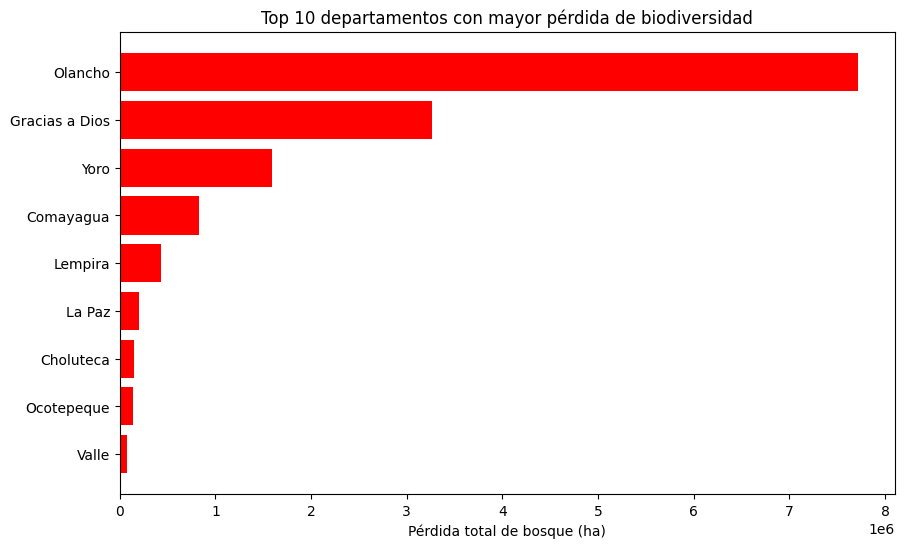

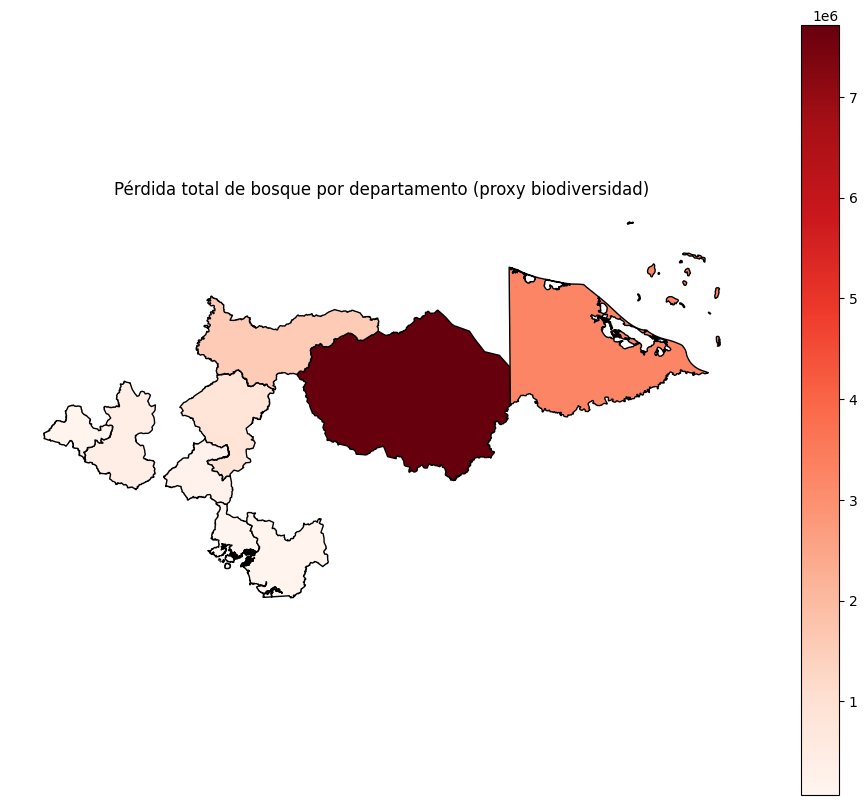

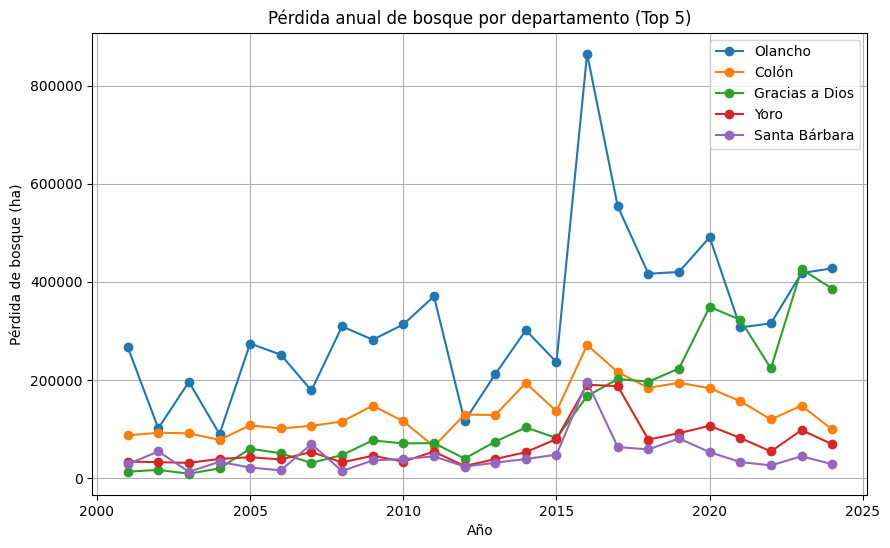

In [19]:
# === 1️. Cargar shapefiles ===
gdf_depts = gpd.read_file("datasets/Departamentos_Honduras.shp")  # Departamentos
gdf_species = gpd.read_file("datasets/data_0.shp")   # Especies

# Asegurar mismo CRS
gdf_species = gdf_species.to_crs(gdf_depts.crs)

# === 2️. Contar especies por departamento ===
species_in_dept = gpd.sjoin(gdf_species, gdf_depts, how="inner", predicate="intersects")
species_stats = species_in_dept.groupby("DEPTO")["SCI_NAME"].nunique().reset_index()
species_stats.rename(columns={"SCI_NAME":"num_species"}, inplace=True)

# === 3️. Cargar datos de deforestación ===
file_path = "datasets/HND (2).xlsx"
sheets_deforestation = ["Subnational 1 tree cover loss", "Subnational 2 tree cover loss"]

dfs = []
for sheet in sheets_deforestation:
    df = pd.read_excel(file_path, sheet_name=sheet)
    dfs.append(df)

# Combinar hojas
df_loss = pd.concat(dfs, ignore_index=True)

# Limpiar columnas y renombrar
df_loss.rename(columns={'subnational1': 'DEPTO'}, inplace=True)

# Convertir los años de pérdida a formato largo
year_cols = [col for col in df_loss.columns if col.startswith('tc_loss_ha_')]
df_loss_long = df_loss.melt(id_vars=['DEPTO'], value_vars=year_cols,
                             var_name='year', value_name='loss_ha')

# Extraer el año como número
df_loss_long['year'] = df_loss_long['year'].str.extract('(\d+)$').astype(int)

# Agrupar pérdida anual por departamento
loss_stats = df_loss_long.groupby(['DEPTO','year'])['loss_ha'].sum().reset_index()

# Pérdida total por departamento
loss_total = loss_stats.groupby("DEPTO")["loss_ha"].sum().reset_index()

# === 4️. Unir datos de pérdida y especies al shapefile ===
gdf_depts = gdf_depts.merge(loss_total, on="DEPTO", how="left")
gdf_depts = gdf_depts.merge(species_stats, on="DEPTO", how="left")

# Pérdida relativa por número de especies (opcional)
gdf_depts['loss_per_species'] = gdf_depts['loss_ha'] / gdf_depts['num_species']

# === 5️. Top 10 departamentos con mayor pérdida total ===
top10_loss = gdf_depts.nlargest(10, 'loss_ha')

plt.figure(figsize=(10,6))
plt.barh(top10_loss['DEPTO'], top10_loss['loss_ha'], color='red')
plt.xlabel("Pérdida total de bosque (ha)")
plt.title("Top 10 departamentos con mayor pérdida de biodiversidad")
plt.gca().invert_yaxis()
plt.show()

# === 6️. Mapa temático de pérdida total ===
fig, ax = plt.subplots(1,1, figsize=(12,10))
gdf_depts.plot(column='loss_ha', cmap='Reds', legend=True, edgecolor='black', ax=ax)
ax.set_title("Pérdida total de bosque por departamento (proxy biodiversidad)")
ax.axis("off")
plt.show()

# === 7️. Gráfico de línea anual solo top 5 departamentos ===
top5_depts = loss_total.nlargest(5, 'loss_ha')['DEPTO'].tolist()
loss_top5 = loss_stats[loss_stats["DEPTO"].isin(top5_depts)]

plt.figure(figsize=(10,6))
for dept in top5_depts:
    dept_data = loss_top5[loss_top5["DEPTO"] == dept]
    plt.plot(dept_data["year"], dept_data["loss_ha"], marker='o', label=dept)

plt.title("Pérdida anual de bosque por departamento (Top 5)")
plt.xlabel("Año")
plt.ylabel("Pérdida de bosque (ha)")
plt.legend()
plt.grid(True)
plt.show()




# Análisis de deforestación en Honduras: Top 5 departamentos y predicciones con regresión lineal

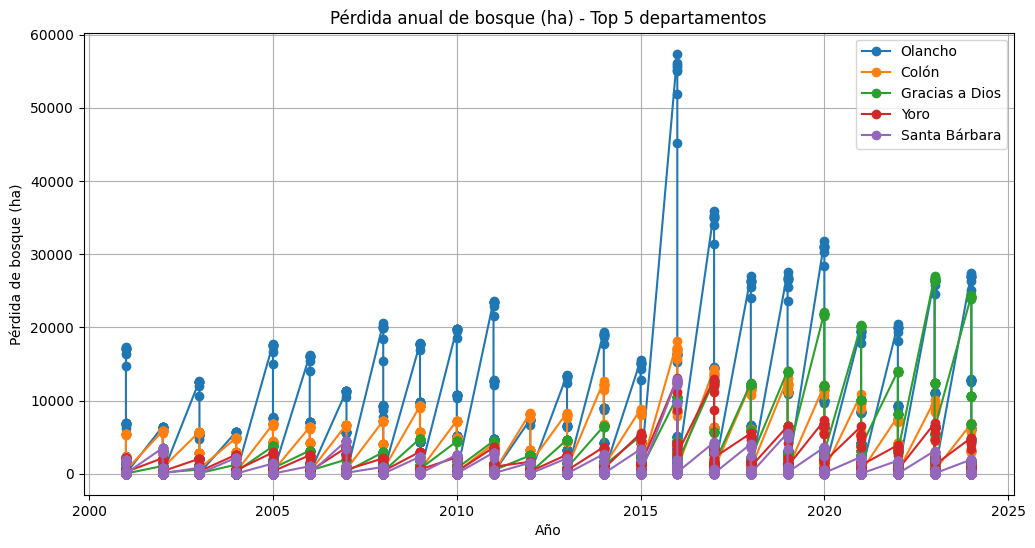

=== Olancho ===
R2: 0.01 RMSE: 4800.26


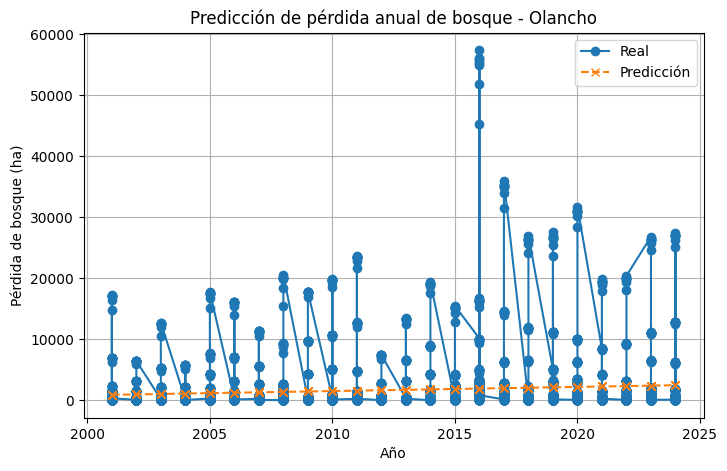

=== Colón ===
R2: 0.012 RMSE: 2700.07


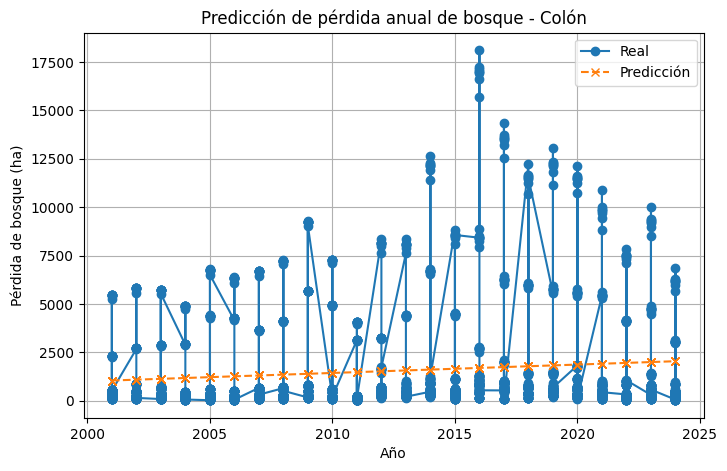

=== Gracias a Dios ===
R2: 0.206 RMSE: 3899.56


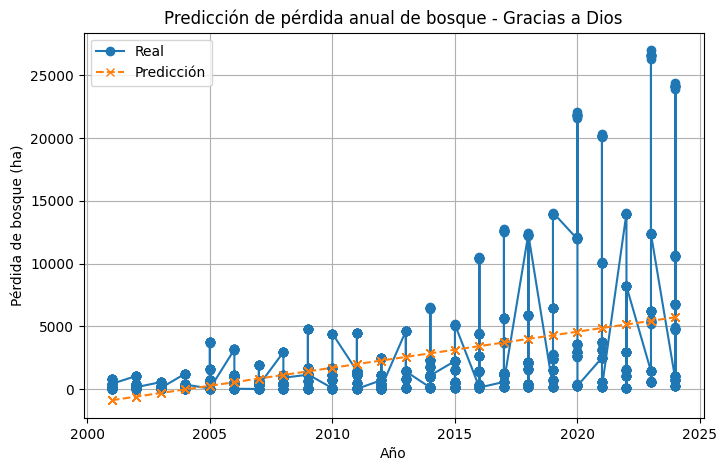

=== Yoro ===
R2: 0.031 RMSE: 1397.03


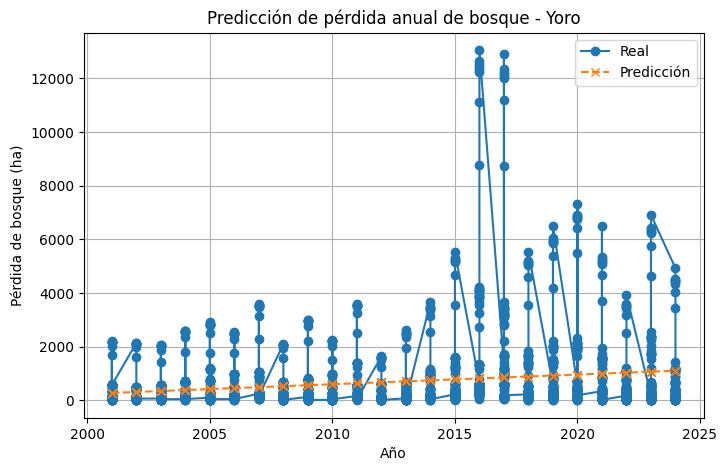

=== Santa Bárbara ===
R2: 0.003 RMSE: 669.91


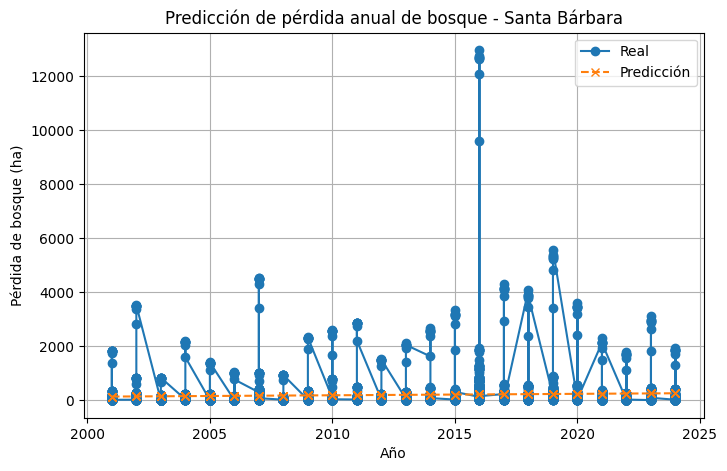

In [20]:
# === 1️. Cargar datos de deforestación ===
file_path = "datasets/HND (2).xlsx"
sheets_deforestation = ["Subnational 1 tree cover loss", "Subnational 2 tree cover loss"]

dfs = []
for sheet in sheets_deforestation:
    df = pd.read_excel(file_path, sheet_name=sheet)
    dfs.append(df)

df_loss = pd.concat(dfs, ignore_index=True)

# Transformar a formato "long" (año vs pérdida)
years = [f"tc_loss_ha_{y}" for y in range(2001, 2025)]
df_long = df_loss.melt(id_vars=["subnational1"], value_vars=years,
                       var_name="Year", value_name="loss_ha")

# Limpiar nombres de año
df_long["Year"] = df_long["Year"].str.replace("tc_loss_ha_", "").astype(int)

# === 2️. Calcular pérdida total por departamento y seleccionar top 5 ===
loss_total = df_long.groupby("subnational1")["loss_ha"].sum().reset_index()
top5_depts = loss_total.nlargest(5, "loss_ha")["subnational1"].tolist()

# Filtrar solo top 5
df_top5 = df_long[df_long["subnational1"].isin(top5_depts)]

# === 3️. Gráfico de pérdida anual por departamento (top 5) ===
plt.figure(figsize=(12,6))
for dept in top5_depts:
    dept_data = df_top5[df_top5["subnational1"] == dept]
    plt.plot(dept_data["Year"], dept_data["loss_ha"], marker="o", label=dept)

plt.title("Pérdida anual de bosque (ha) - Top 5 departamentos")
plt.xlabel("Año")
plt.ylabel("Pérdida de bosque (ha)")
plt.legend()
plt.grid(True)
plt.show()

# === 4️. Modelo predictivo: regresión lineal por departamento ===
for dept in top5_depts:
    dept_data = df_top5[df_top5["subnational1"] == dept].sort_values("Year")
    X = dept_data["Year"].values.reshape(-1,1)
    y = dept_data["loss_ha"].values

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Métricas
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    print(f"=== {dept} ===")
    print("R2:", round(r2,3), "RMSE:", round(rmse,2))

    # Gráfico de predicción vs real
    plt.figure(figsize=(8,5))
    plt.plot(dept_data["Year"], y, marker="o", label="Real")
    plt.plot(dept_data["Year"], y_pred, marker="x", linestyle="--", label="Predicción")
    plt.title(f"Predicción de pérdida anual de bosque - {dept}")
    plt.xlabel("Año")
    plt.ylabel("Pérdida de bosque (ha)")
    plt.legend()
    plt.grid(True)
    plt.show()


# Análisis geoespacial y predicción de pérdida de bosque en Honduras (Top 5 departamentos)

=== Olancho ===
R2: 0.01 RMSE: 4800.26


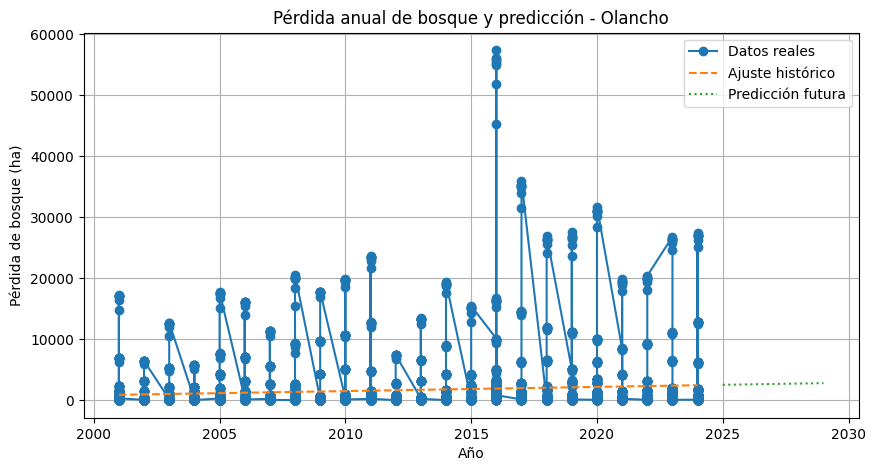

=== Colón ===
R2: 0.012 RMSE: 2700.07


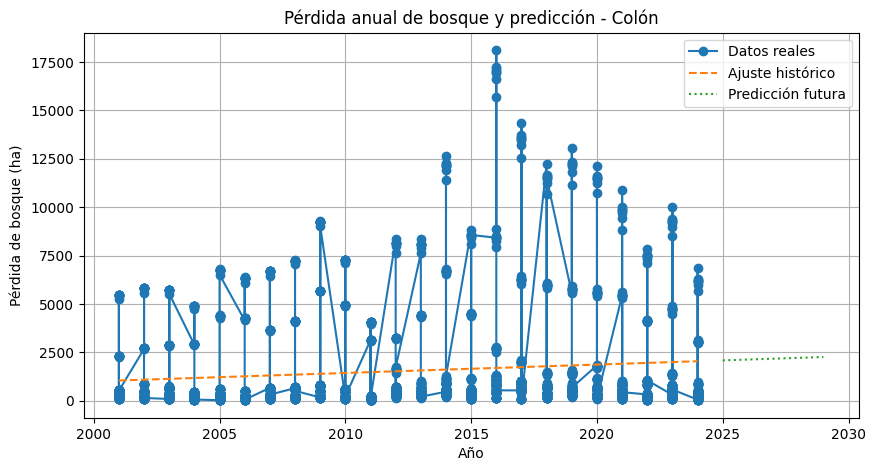

=== Gracias a Dios ===
R2: 0.206 RMSE: 3899.56


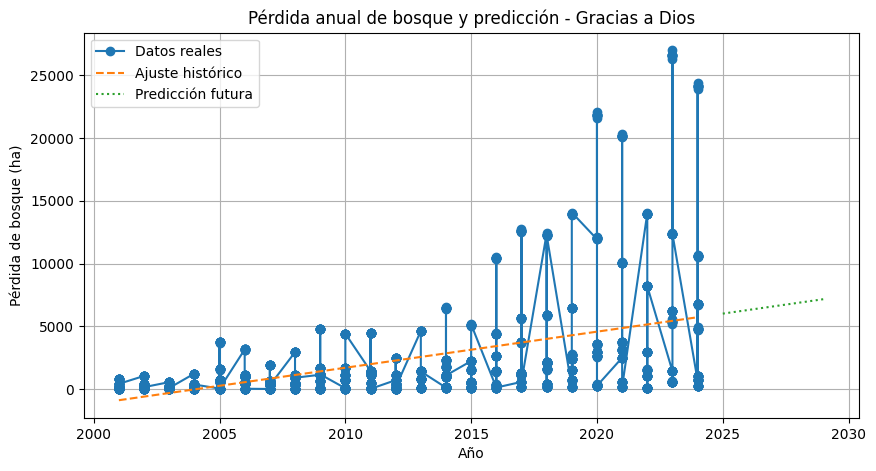

=== Yoro ===
R2: 0.031 RMSE: 1397.03


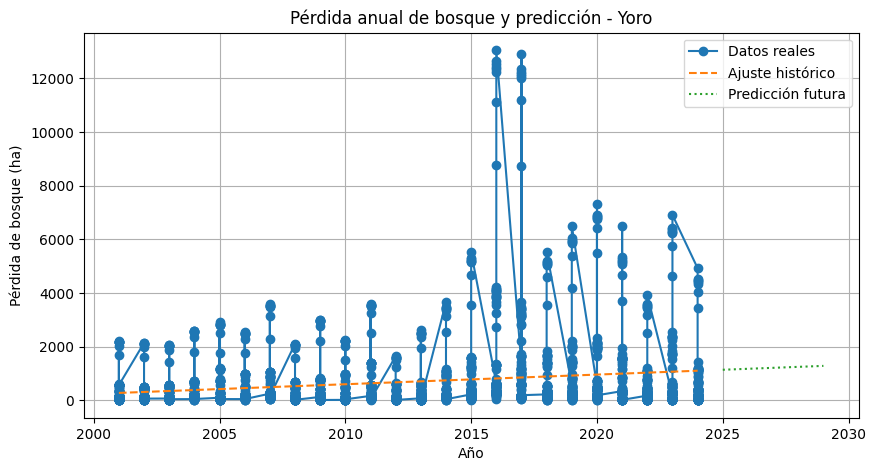

=== Santa Bárbara ===
R2: 0.003 RMSE: 669.91


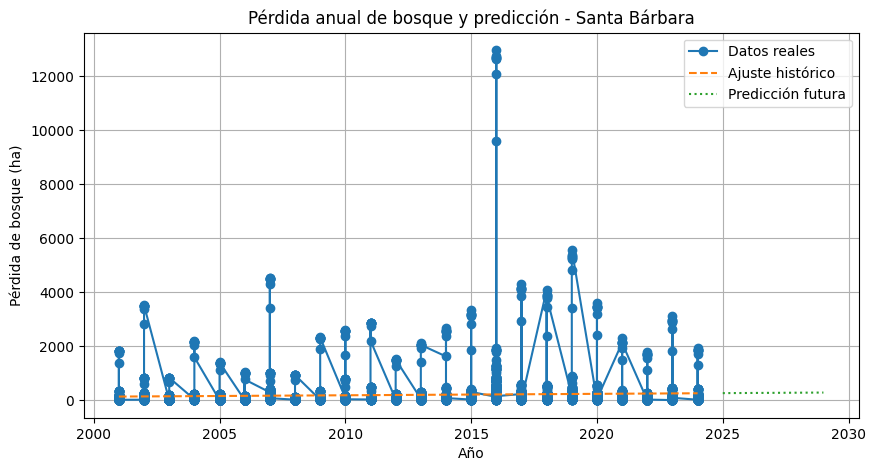

In [22]:
# === 1️. Cargar shapefile de departamentos ===
gdf_depts = gpd.read_file("datasets/Departamentos_Honduras.shp")

# === 2️. Cargar datos de deforestación ===
file_path = "datasets/HND (2).xlsx"
sheets_deforestation = ["Subnational 1 tree cover loss", "Subnational 2 tree cover loss"]

dfs = []
for sheet in sheets_deforestation:
    df = pd.read_excel(file_path, sheet_name=sheet)
    dfs.append(df)

df_loss = pd.concat(dfs, ignore_index=True)

# Melt para tener columnas: 'subnational1', 'Year', 'loss_ha'
years = list(range(2001, 2025))
df_melted = df_loss.melt(
    id_vars=['subnational1'],
    value_vars=[f'tc_loss_ha_{y}' for y in years],
    var_name='Year', value_name='loss_ha'
)
df_melted['Year'] = df_melted['Year'].str.extract(r'(\d+)$').astype(int)  # raw string

# === 3️. Top 5 departamentos con mayor pérdida total ===
loss_total = df_melted.groupby('subnational1')['loss_ha'].sum().reset_index()
top5_depts = loss_total.nlargest(5, 'loss_ha')['subnational1'].tolist()
df_top5 = df_melted[df_melted['subnational1'].isin(top5_depts)]

# === 4️. Modelo predictivo y gráficos por departamento ===
future_years = np.array(range(2025, 2030)).reshape(-1,1)

for dept in top5_depts:
    df_dept = df_top5[df_top5['subnational1']==dept].sort_values('Year')
    X = df_dept['Year'].values.reshape(-1,1)
    y = df_dept['loss_ha'].values

    model = LinearRegression()
    model.fit(X, y)

    # Predicción histórica y futura
    y_pred = model.predict(X)
    y_future = model.predict(future_years)

    # Métricas
    r2 = r2_score(y, y_pred)
    rmse = mean_squared_error(y, y_pred) ** 0.5
    print(f"=== {dept} ===")
    print("R2:", round(r2,3), "RMSE:", round(rmse,2))

    # Gráfico individual
    plt.figure(figsize=(10,5))
    plt.plot(df_dept['Year'], y, marker='o', label='Datos reales')
    plt.plot(df_dept['Year'], y_pred, linestyle='--', label='Ajuste histórico')
    plt.plot(future_years, y_future, linestyle=':', label='Predicción futura')
    plt.xlabel("Año")
    plt.ylabel("Pérdida de bosque (ha)")
    plt.title(f"Pérdida anual de bosque y predicción - {dept}")
    plt.legend()
    plt.grid(True)
    plt.show()


# Análisis de relación entre emisiones de carbono y cambio de temperatura en Honduras

Correlación emisiones CO2 vs temperatura: 0.6751984087249912
p-value: 0.00029466940839483196


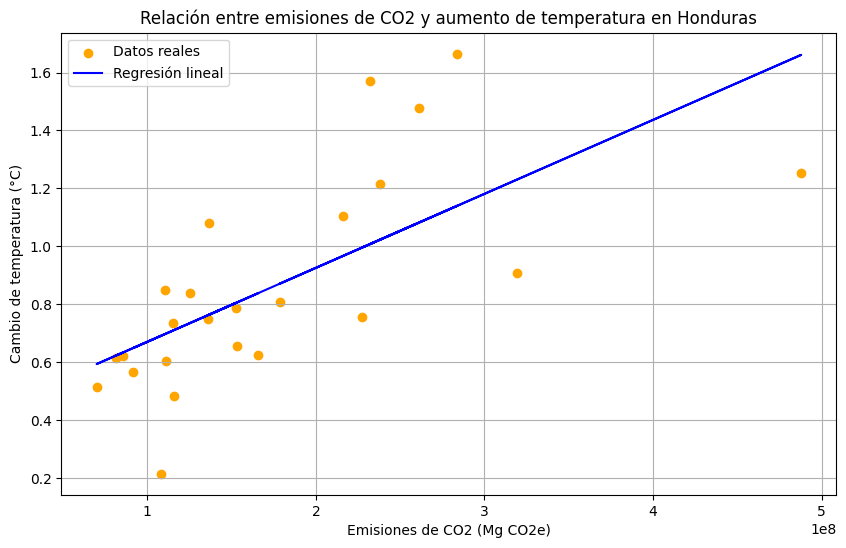

In [3]:
# === 1️. Cargar datasets ===
file_carbon = "datasets/HND (2).xlsx"
sheets_carbon = ["Subnational 1 carbon data", "Subnational 2 carbon data"]

df_carbon = pd.concat([pd.read_excel(file_carbon, sheet_name=s) for s in sheets_carbon], ignore_index=True)

file_temp = "datasets/23_Annual_Surface_Temperature_Change.csv"
df_temp = pd.read_csv(file_temp, low_memory=False)

# === 2️. Filtrar por Honduras ===
df_temp = df_temp[df_temp["Country"]=="Honduras"]
df_carbon = df_carbon[df_carbon["country"]=="Honduras"]

# === 3️. Transformar emisiones de carbono de wide a long ===
carbon_cols = [c for c in df_carbon.columns if c.startswith("gfw_forest_carbon_gross_emissions_")]
df_carbon_long = df_carbon.melt(id_vars=["subnational1"], value_vars=carbon_cols,
                                var_name="year", value_name="emissions_MgCO2e")

# Extraer año de nombre de columna y eliminar filas inválidas
df_carbon_long["year"] = df_carbon_long["year"].str.extract(r"(\d{4})")
df_carbon_long = df_carbon_long.dropna(subset=["year"])  # eliminar filas sin año
df_carbon_long["year"] = df_carbon_long["year"].astype(int)

# Agrupar por año (si hay más de un subnational1)
df_carbon_yearly = df_carbon_long.groupby("year")["emissions_MgCO2e"].sum().reset_index()

# === 4️⃣ Transformar temperatura de wide a long ===
year_cols = [str(y) for y in range(1961, 2025)]
df_temp_long = df_temp[["Country"] + year_cols].melt(id_vars=["Country"], value_vars=year_cols,
                                                    var_name="year", value_name="temperature_change")
df_temp_long["year"] = df_temp_long["year"].astype(int)
df_temp_long["temperature_change"] = pd.to_numeric(df_temp_long["temperature_change"], errors="coerce")
df_temp_long = df_temp_long.dropna(subset=["temperature_change"])

# === 5️⃣ Unir datasets por año ===
df_merge = pd.merge(df_carbon_yearly, df_temp_long, on="year", how="inner")

# === 6️⃣ Calcular correlación ===
corr, p_val = pearsonr(df_merge["emissions_MgCO2e"], df_merge["temperature_change"])
print("Correlación emisiones CO2 vs temperatura:", corr)
print("p-value:", p_val)

# === 7️⃣ Regresión lineal ===
X = df_merge["emissions_MgCO2e"].values.reshape(-1,1)
y = df_merge["temperature_change"].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# === 8️⃣ Gráfico ===
plt.figure(figsize=(10,6))
plt.scatter(df_merge["emissions_MgCO2e"], df_merge["temperature_change"], color='orange', label='Datos reales')
plt.plot(df_merge["emissions_MgCO2e"], y_pred, color='blue', label='Regresión lineal')
plt.xlabel("Emisiones de CO2 (Mg CO2e)")
plt.ylabel("Cambio de temperatura (°C)")
plt.title("Relación entre emisiones de CO2 y aumento de temperatura en Honduras")
plt.legend()
plt.grid(True)
plt.show()